In [ ]:
# Run Date: Friday, June 02, 2023
# Run Time: 04:39:20

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# ⚡️ Energy-Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent ['Deep Energy-Based Generative Models' tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) created by Phillip Lippe.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

from notebooks.utils import display, sample_batch
import random

2023-06-02 19:52:33.176235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 19:52:33.286214: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [4]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

In [5]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

2023-06-02 19:52:35.213352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 19:52:35.213544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 19:52:35.215554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 19:52:35.215708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 19:52:35.215850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

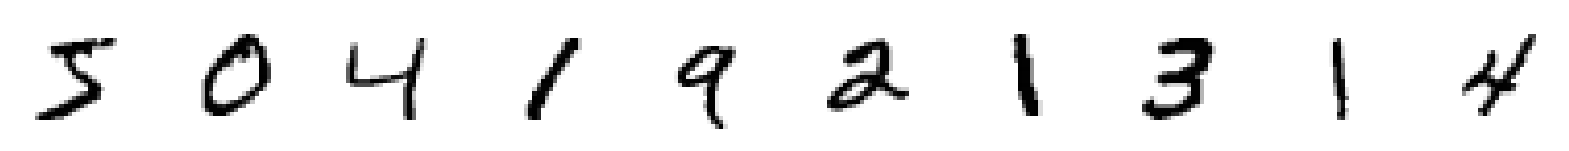

In [7]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

In [8]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448 

In [9]:
if LOAD_MODEL:
    model.load_weights("07_01_ebm/models/model.h5")

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [10]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [11]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [12]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [13]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [14]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [15]:
tensorboard_callback = callbacks.TensorBoard(log_dir="07_01_ebm/logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="07_01_ebm/output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="07_01_ebm/output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [16]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("07_01_ebm/models/model.h5")


save_model_callback = SaveModel()

Epoch 1/60


2023-06-02 19:52:37.678192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


469/469 [==============================] - ETA: 0s - loss: -0.0344 - reg: 0.0133 - cdiv: -0.0477 - real: 0.2069 - fake: 0.1592
Saved to 07_01_ebm/output/generated_img_000.png


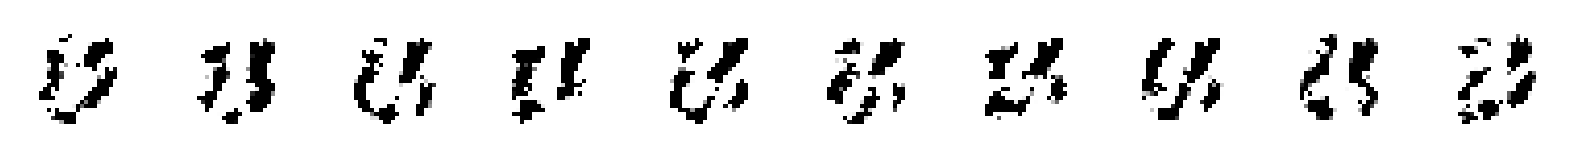


Saved to 07_01_ebm/output/example_img_000.png


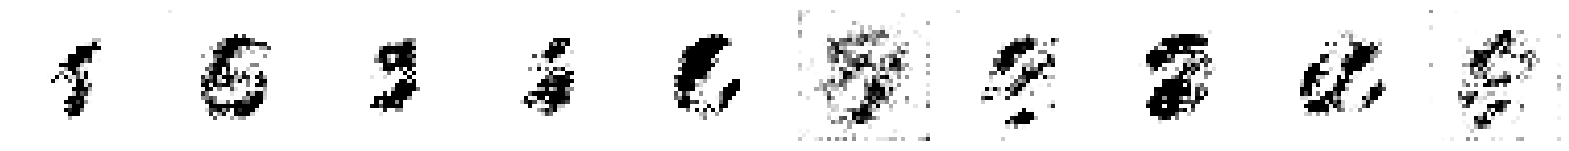

469/469 [==============================] - 275s 584ms/step - loss: -0.0344 - reg: 0.0133 - cdiv: -0.0477 - real: 0.2069 - fake: 0.1592 - val_cdiv: -1.1981 - val_real: -0.1040 - val_fake: -1.3021
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -0.0040 - reg: 0.0019 - cdiv: -0.0059 - real: 0.0122 - fake: 0.0063
Saved to 07_01_ebm/output/generated_img_001.png


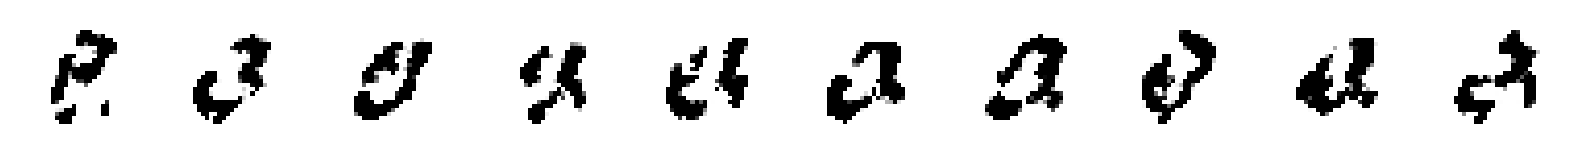


Saved to 07_01_ebm/output/example_img_001.png


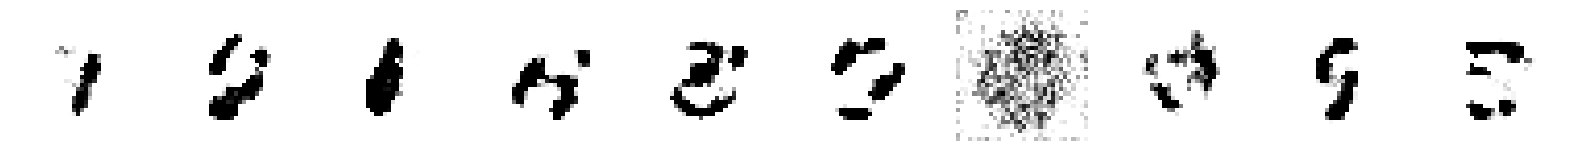

469/469 [==============================] - 273s 583ms/step - loss: -0.0040 - reg: 0.0019 - cdiv: -0.0059 - real: 0.0122 - fake: 0.0063 - val_cdiv: -1.6336 - val_real: -0.0766 - val_fake: -1.7102
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: -9.9959e-04 - reg: 9.2174e-04 - cdiv: -0.0019 - real: 0.0038 - fake: 0.0019
Saved to 07_01_ebm/output/generated_img_002.png


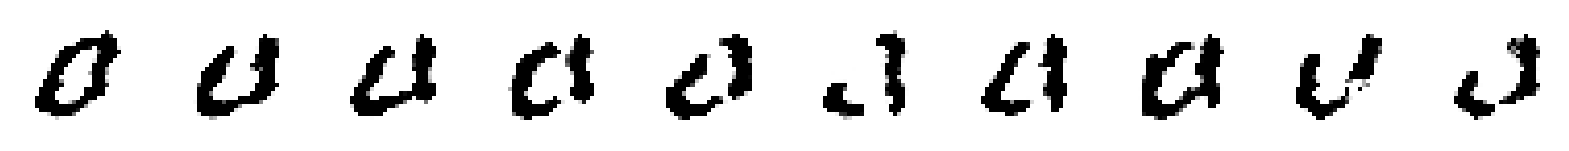


Saved to 07_01_ebm/output/example_img_002.png


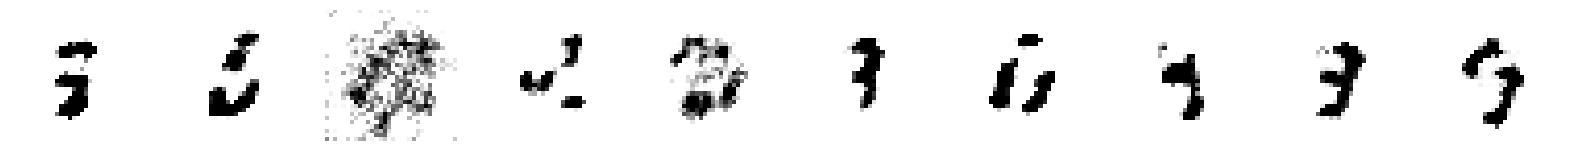

469/469 [==============================] - 273s 582ms/step - loss: -9.9959e-04 - reg: 9.2174e-04 - cdiv: -0.0019 - real: 0.0038 - fake: 0.0019 - val_cdiv: -1.9548 - val_real: -0.0480 - val_fake: -2.0028
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: 2.6302e-04 - reg: 4.5447e-04 - cdiv: -1.9145e-04 - real: 0.0022 - fake: 0.0020
Saved to 07_01_ebm/output/generated_img_003.png


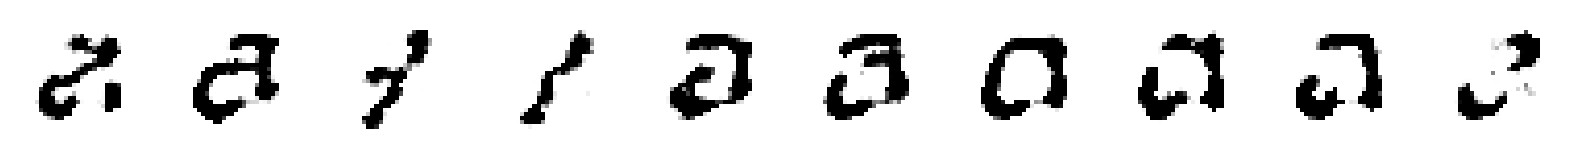


Saved to 07_01_ebm/output/example_img_003.png


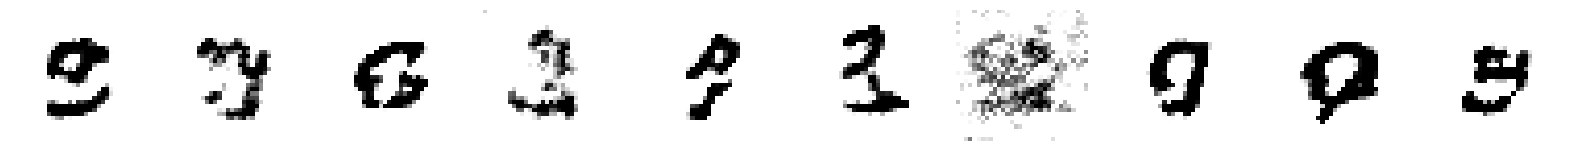

469/469 [==============================] - 270s 576ms/step - loss: 2.6302e-04 - reg: 4.5447e-04 - cdiv: -1.9145e-04 - real: 0.0022 - fake: 0.0020 - val_cdiv: -2.2450 - val_real: 0.0196 - val_fake: -2.2255
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: 2.9544e-04 - reg: 2.6738e-04 - cdiv: 2.8057e-05 - real: 9.0858e-04 - fake: 9.3663e-04
Saved to 07_01_ebm/output/generated_img_004.png


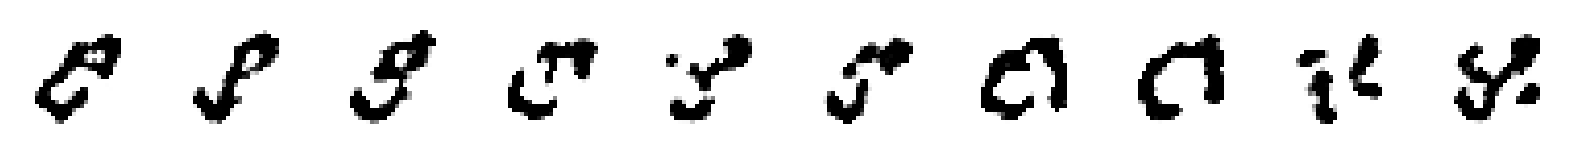


Saved to 07_01_ebm/output/example_img_004.png


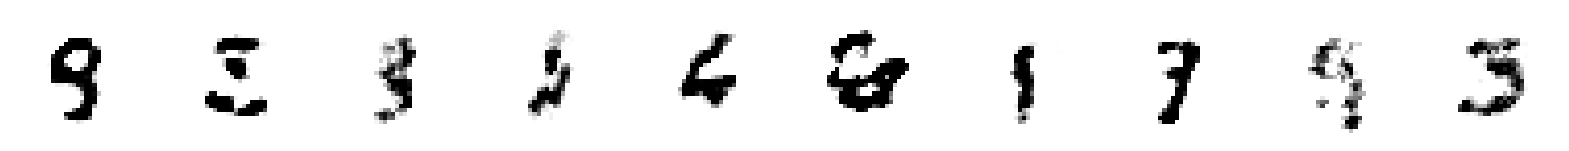

469/469 [==============================] - 267s 568ms/step - loss: 2.9544e-04 - reg: 2.6738e-04 - cdiv: 2.8057e-05 - real: 9.0858e-04 - fake: 9.3663e-04 - val_cdiv: -2.4740 - val_real: 0.0238 - val_fake: -2.4502
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: 3.3648e-04 - reg: 3.0330e-04 - cdiv: 3.3179e-05 - real: 0.0010 - fake: 0.0011      
Saved to 07_01_ebm/output/generated_img_005.png


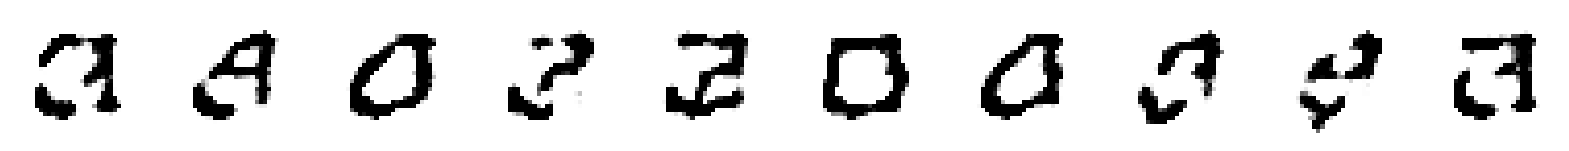


Saved to 07_01_ebm/output/example_img_005.png


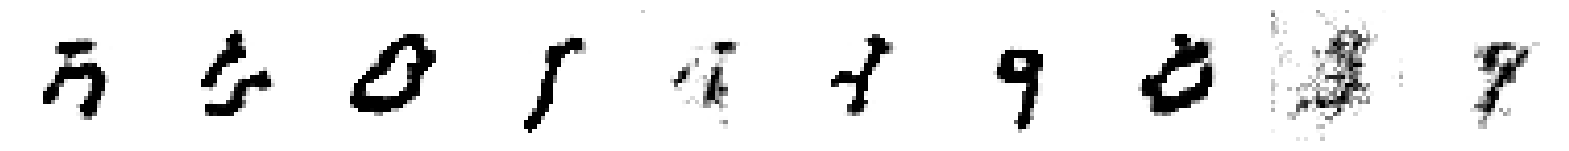

469/469 [==============================] - 273s 582ms/step - loss: 3.3648e-04 - reg: 3.0330e-04 - cdiv: 3.3179e-05 - real: 0.0010 - fake: 0.0011 - val_cdiv: -2.7182 - val_real: 0.0298 - val_fake: -2.6884
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: 1.5092e-04 - reg: 3.6922e-04 - cdiv: -2.1830e-04 - real: 0.0015 - fake: 0.0013
Saved to 07_01_ebm/output/generated_img_006.png


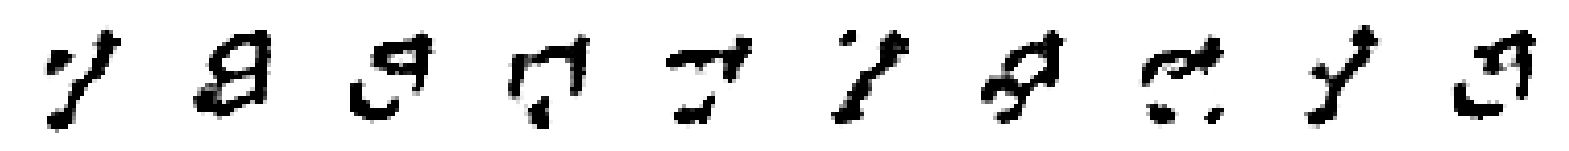


Saved to 07_01_ebm/output/example_img_006.png


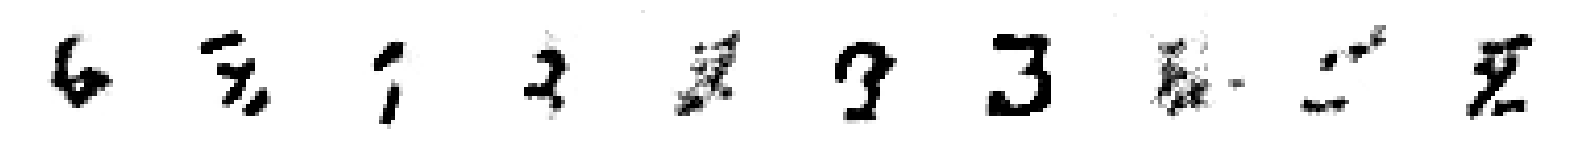

469/469 [==============================] - 274s 585ms/step - loss: 1.5092e-04 - reg: 3.6922e-04 - cdiv: -2.1830e-04 - real: 0.0015 - fake: 0.0013 - val_cdiv: -2.9876 - val_real: 0.0291 - val_fake: -2.9585
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: -1.4039e-04 - reg: 3.4468e-04 - cdiv: -4.8506e-04 - real: 0.0014 - fake: 9.5628e-04
Saved to 07_01_ebm/output/generated_img_007.png


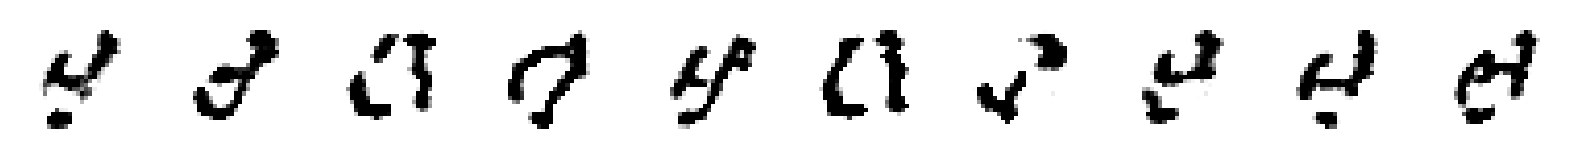


Saved to 07_01_ebm/output/example_img_007.png


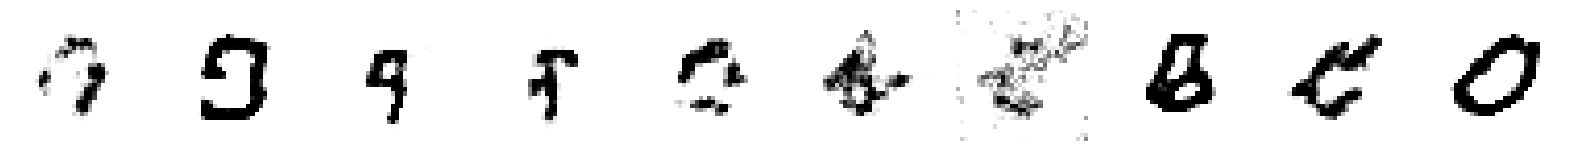

469/469 [==============================] - 272s 581ms/step - loss: -1.4039e-04 - reg: 3.4468e-04 - cdiv: -4.8506e-04 - real: 0.0014 - fake: 9.5628e-04 - val_cdiv: -3.3481 - val_real: 0.0306 - val_fake: -3.3175
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: -5.2816e-04 - reg: 4.2481e-04 - cdiv: -9.5297e-04 - real: 0.0017 - fake: 7.3882e-04
Saved to 07_01_ebm/output/generated_img_008.png


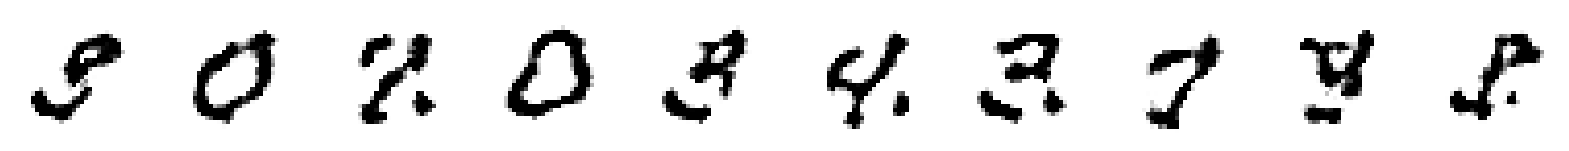


Saved to 07_01_ebm/output/example_img_008.png


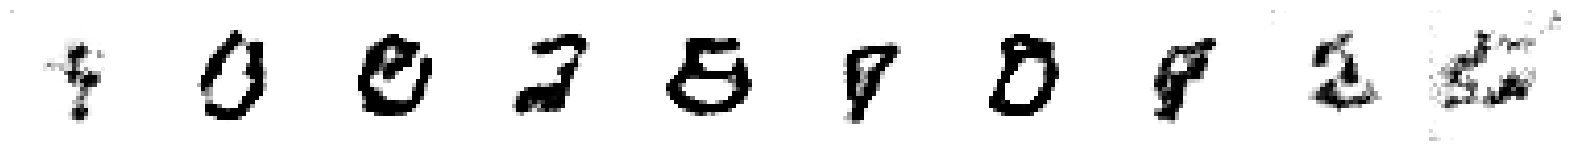

469/469 [==============================] - 273s 583ms/step - loss: -5.2816e-04 - reg: 4.2481e-04 - cdiv: -9.5297e-04 - real: 0.0017 - fake: 7.3882e-04 - val_cdiv: -3.8210 - val_real: 0.0530 - val_fake: -3.7680
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: 2.6851e-04 - reg: 2.9478e-04 - cdiv: -2.6268e-05 - real: 0.0011 - fake: 0.0010        
Saved to 07_01_ebm/output/generated_img_009.png


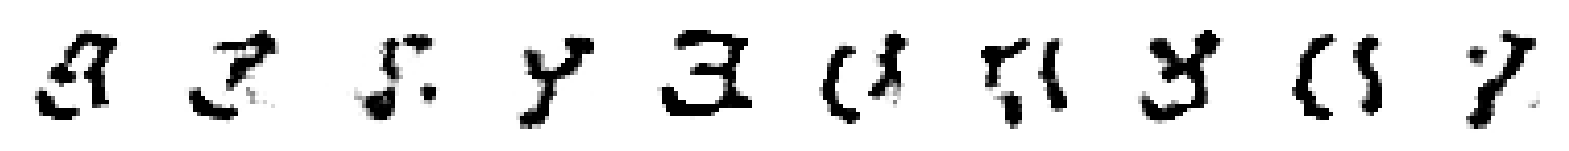


Saved to 07_01_ebm/output/example_img_009.png


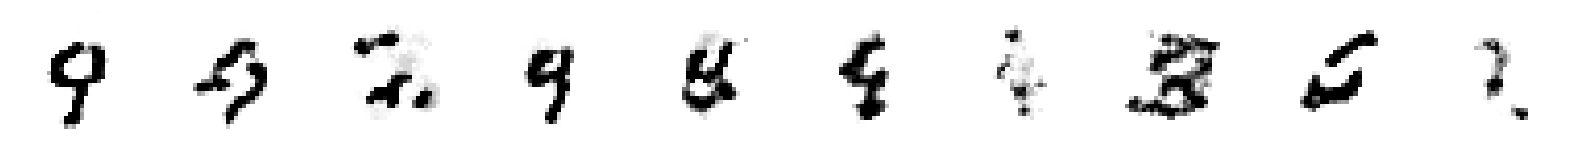

469/469 [==============================] - 274s 584ms/step - loss: 2.6851e-04 - reg: 2.9478e-04 - cdiv: -2.6268e-05 - real: 0.0011 - fake: 0.0010 - val_cdiv: -4.0703 - val_real: 0.0436 - val_fake: -4.0266
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: -7.3799e-04 - reg: 2.6308e-04 - cdiv: -0.0010 - real: 0.0015 - fake: 4.8416e-04
Saved to 07_01_ebm/output/generated_img_010.png


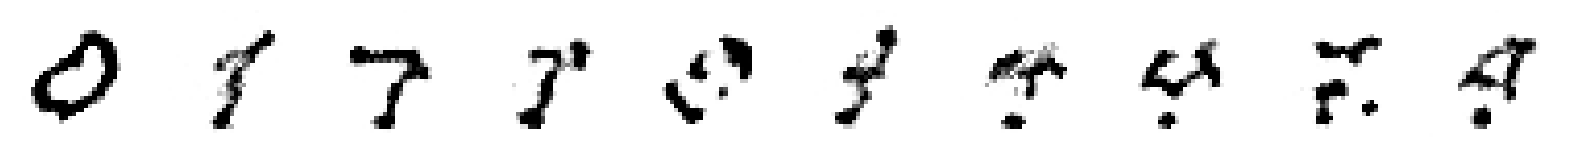


Saved to 07_01_ebm/output/example_img_010.png


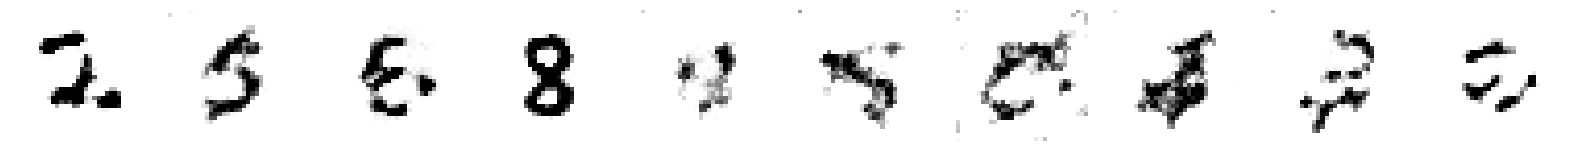

469/469 [==============================] - 274s 584ms/step - loss: -7.3799e-04 - reg: 2.6308e-04 - cdiv: -0.0010 - real: 0.0015 - fake: 4.8416e-04 - val_cdiv: -4.8093 - val_real: 0.0421 - val_fake: -4.7671
Epoch 12/60
469/469 [==============================] - ETA: 0s - loss: 7.1005e-05 - reg: 2.1723e-04 - cdiv: -1.4622e-04 - real: 0.0011 - fake: 9.2792e-04   
Saved to 07_01_ebm/output/generated_img_011.png


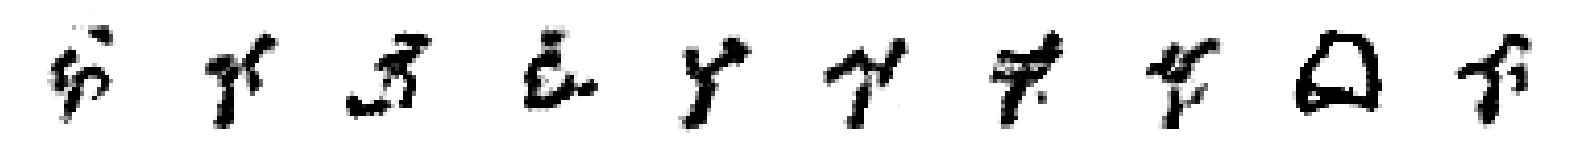


Saved to 07_01_ebm/output/example_img_011.png


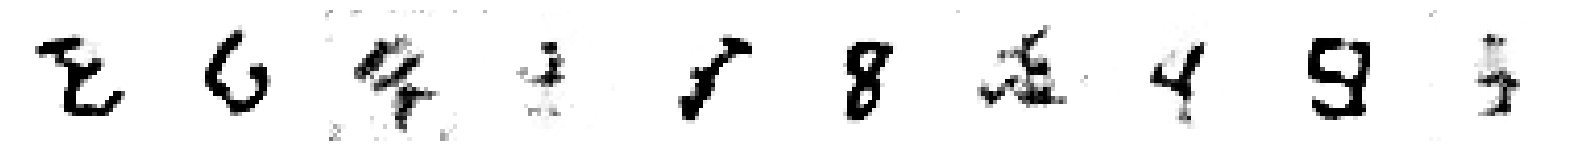

469/469 [==============================] - 268s 570ms/step - loss: 7.1005e-05 - reg: 2.1723e-04 - cdiv: -1.4622e-04 - real: 0.0011 - fake: 9.2792e-04 - val_cdiv: -4.9680 - val_real: 0.0227 - val_fake: -4.9453
Epoch 13/60
469/469 [==============================] - ETA: 0s - loss: -4.0724e-04 - reg: 1.8318e-04 - cdiv: -5.9042e-04 - real: 0.0011 - fake: 5.0913e-04  
Saved to 07_01_ebm/output/generated_img_012.png


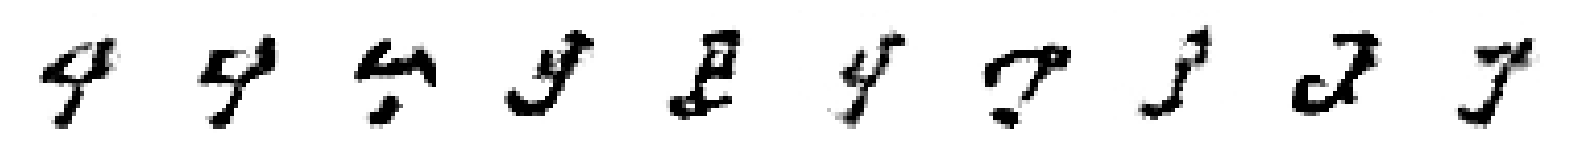


Saved to 07_01_ebm/output/example_img_012.png


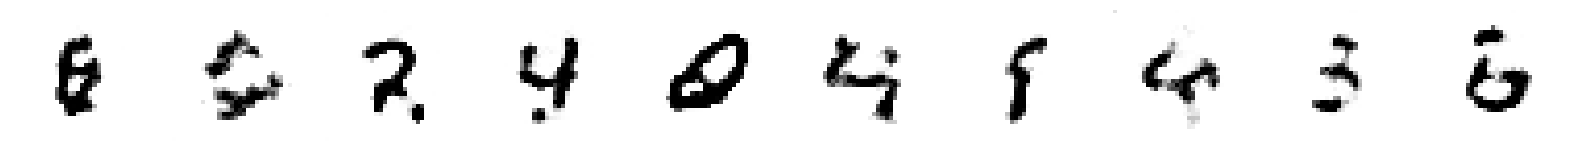

469/469 [==============================] - 275s 586ms/step - loss: -4.0724e-04 - reg: 1.8318e-04 - cdiv: -5.9042e-04 - real: 0.0011 - fake: 5.0913e-04 - val_cdiv: -5.4581 - val_real: 0.0227 - val_fake: -5.4354
Epoch 14/60
469/469 [==============================] - ETA: 0s - loss: 2.3639e-04 - reg: 2.3789e-04 - cdiv: -1.5024e-06 - real: 7.7129e-04 - fake: 7.6979e-04
Saved to 07_01_ebm/output/generated_img_013.png


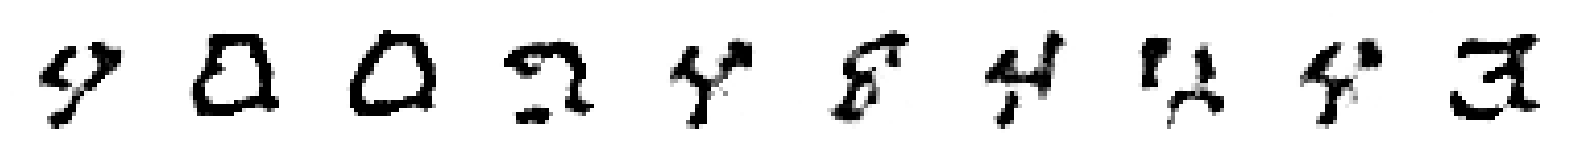


Saved to 07_01_ebm/output/example_img_013.png


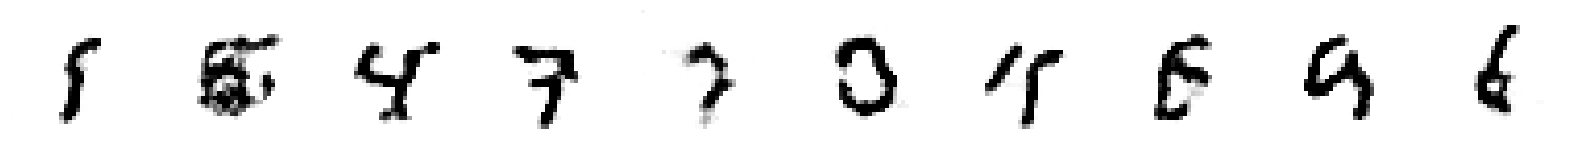

469/469 [==============================] - 276s 588ms/step - loss: 2.3639e-04 - reg: 2.3789e-04 - cdiv: -1.5024e-06 - real: 7.7129e-04 - fake: 7.6979e-04 - val_cdiv: -5.7744 - val_real: 0.0279 - val_fake: -5.7465
Epoch 15/60
469/469 [==============================] - ETA: 0s - loss: -4.3523e-05 - reg: 1.4272e-04 - cdiv: -1.8624e-04 - real: 5.7829e-04 - fake: 3.9205e-04
Saved to 07_01_ebm/output/generated_img_014.png


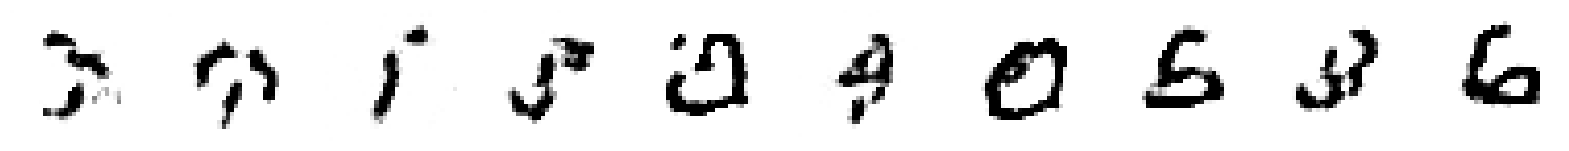


Saved to 07_01_ebm/output/example_img_014.png


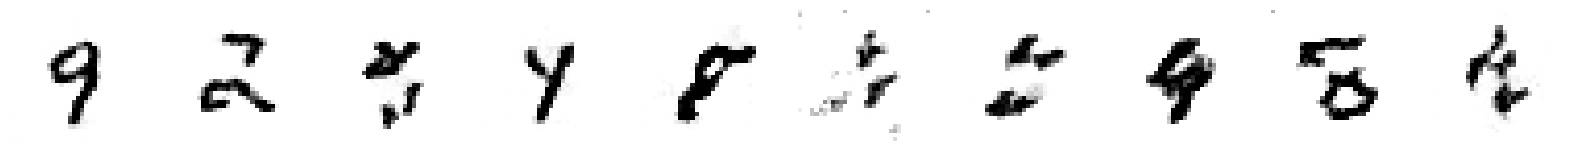

469/469 [==============================] - 275s 585ms/step - loss: -4.3523e-05 - reg: 1.4272e-04 - cdiv: -1.8624e-04 - real: 5.7829e-04 - fake: 3.9205e-04 - val_cdiv: -6.0963 - val_real: 0.0223 - val_fake: -6.0741
Epoch 16/60
469/469 [==============================] - ETA: 0s - loss: 5.9707e-05 - reg: 1.5292e-04 - cdiv: -9.3214e-05 - real: 2.0118e-04 - fake: 1.0797e-04
Saved to 07_01_ebm/output/generated_img_015.png


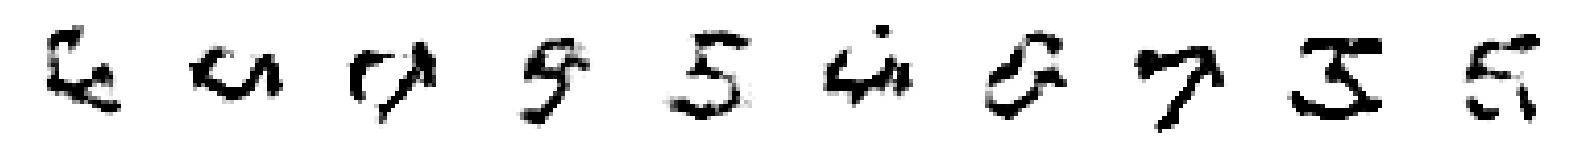


Saved to 07_01_ebm/output/example_img_015.png


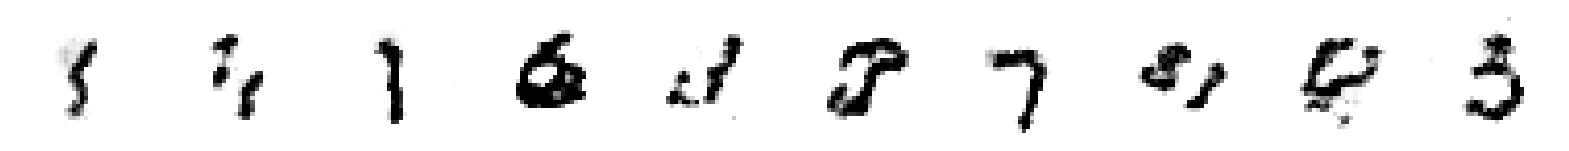

469/469 [==============================] - 273s 582ms/step - loss: 5.9707e-05 - reg: 1.5292e-04 - cdiv: -9.3214e-05 - real: 2.0118e-04 - fake: 1.0797e-04 - val_cdiv: -6.4480 - val_real: 0.0244 - val_fake: -6.4235
Epoch 17/60
469/469 [==============================] - ETA: 0s - loss: -3.1116e-04 - reg: 1.7099e-04 - cdiv: -4.8215e-04 - real: 0.0011 - fake: 6.3501e-04
Saved to 07_01_ebm/output/generated_img_016.png


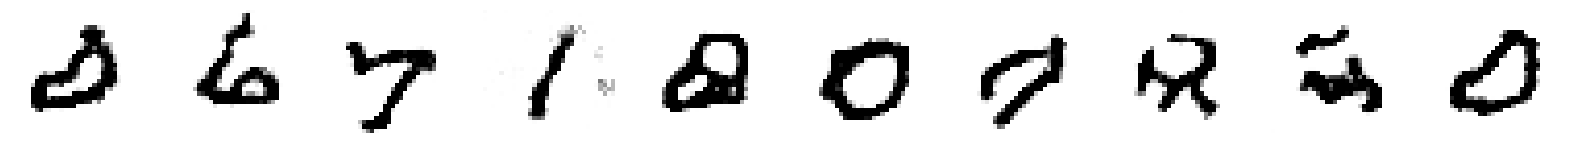


Saved to 07_01_ebm/output/example_img_016.png


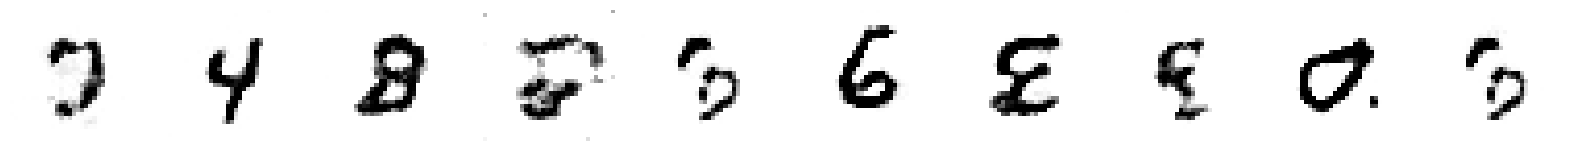

469/469 [==============================] - 275s 585ms/step - loss: -3.1116e-04 - reg: 1.7099e-04 - cdiv: -4.8215e-04 - real: 0.0011 - fake: 6.3501e-04 - val_cdiv: -7.0254 - val_real: 0.0257 - val_fake: -6.9997
Epoch 18/60
469/469 [==============================] - ETA: 0s - loss: -2.5533e-04 - reg: 1.7996e-04 - cdiv: -4.3529e-04 - real: 0.0011 - fake: 6.8889e-04  
Saved to 07_01_ebm/output/generated_img_017.png


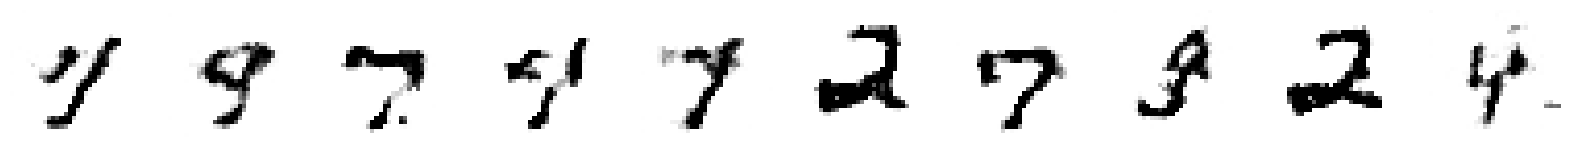


Saved to 07_01_ebm/output/example_img_017.png


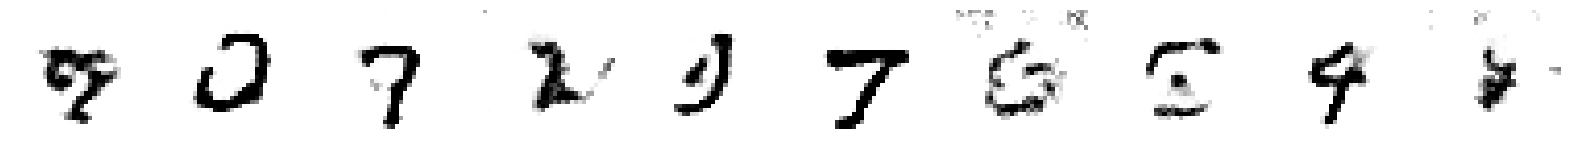

469/469 [==============================] - 276s 588ms/step - loss: -2.5533e-04 - reg: 1.7996e-04 - cdiv: -4.3529e-04 - real: 0.0011 - fake: 6.8889e-04 - val_cdiv: -7.7130 - val_real: 0.0243 - val_fake: -7.6887
Epoch 19/60
469/469 [==============================] - ETA: 0s - loss: 1.2952e-04 - reg: 1.6543e-04 - cdiv: -3.5912e-05 - real: 3.1876e-04 - fake: 2.8284e-04
Saved to 07_01_ebm/output/generated_img_018.png


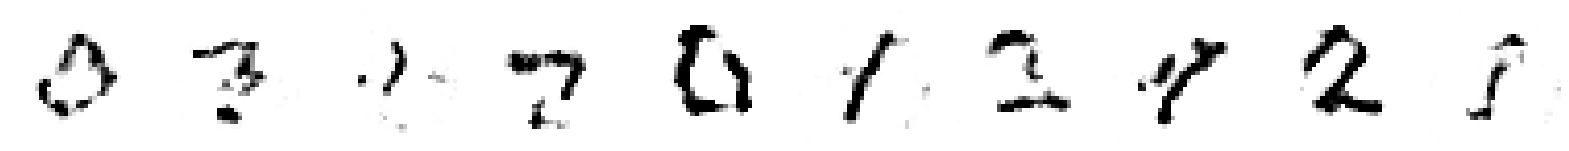


Saved to 07_01_ebm/output/example_img_018.png


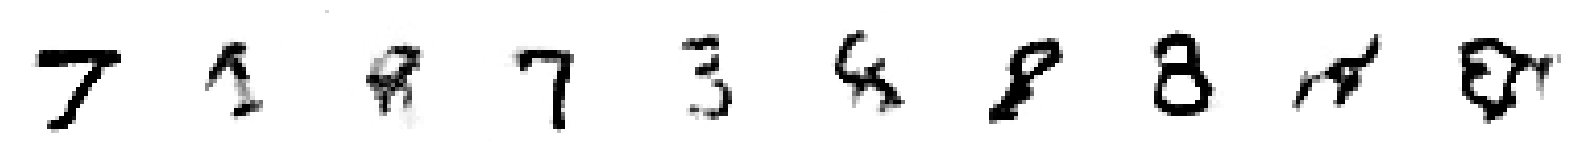

469/469 [==============================] - 274s 585ms/step - loss: 1.2952e-04 - reg: 1.6543e-04 - cdiv: -3.5912e-05 - real: 3.1876e-04 - fake: 2.8284e-04 - val_cdiv: -8.0871 - val_real: 0.0216 - val_fake: -8.0655
Epoch 20/60
469/469 [==============================] - ETA: 0s - loss: -7.4912e-06 - reg: 1.7052e-04 - cdiv: -1.7802e-04 - real: 2.7531e-04 - fake: 9.7291e-05
Saved to 07_01_ebm/output/generated_img_019.png


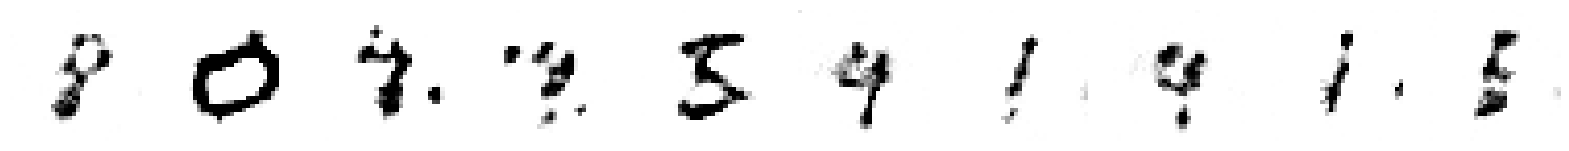


Saved to 07_01_ebm/output/example_img_019.png


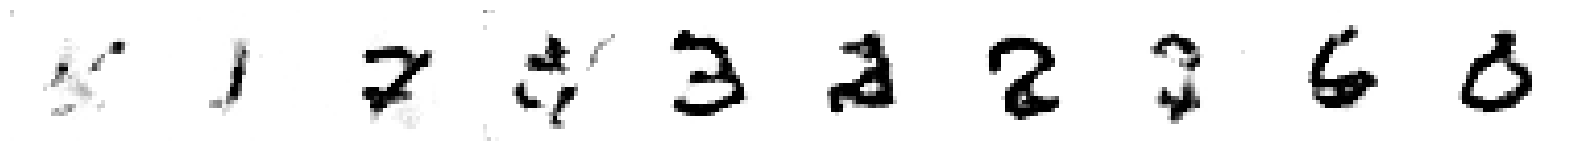

469/469 [==============================] - 274s 584ms/step - loss: -7.4912e-06 - reg: 1.7052e-04 - cdiv: -1.7802e-04 - real: 2.7531e-04 - fake: 9.7291e-05 - val_cdiv: -8.4241 - val_real: 0.0158 - val_fake: -8.4083
Epoch 21/60
469/469 [==============================] - ETA: 0s - loss: 1.6347e-04 - reg: 1.4084e-04 - cdiv: 2.2625e-05 - real: 3.2868e-04 - fake: 3.5131e-04
Saved to 07_01_ebm/output/generated_img_020.png


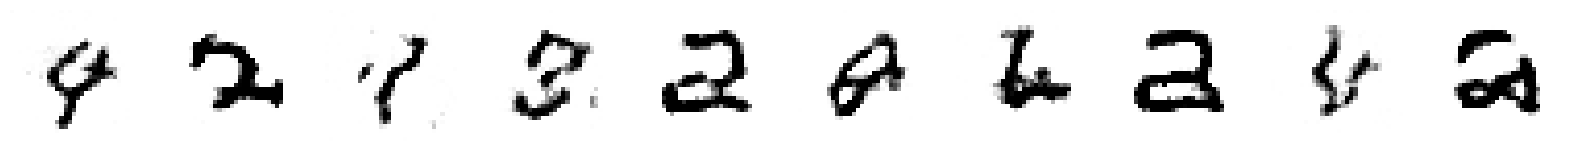


Saved to 07_01_ebm/output/example_img_020.png


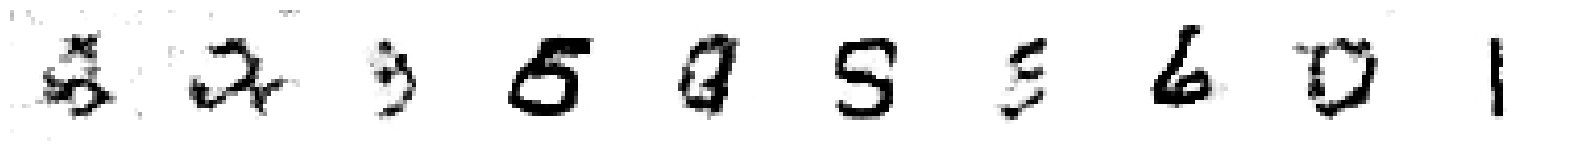

469/469 [==============================] - 274s 584ms/step - loss: 1.6347e-04 - reg: 1.4084e-04 - cdiv: 2.2625e-05 - real: 3.2868e-04 - fake: 3.5131e-04 - val_cdiv: -8.8200 - val_real: 0.0192 - val_fake: -8.8008
Epoch 22/60
469/469 [==============================] - ETA: 0s - loss: 1.3857e-04 - reg: 1.5365e-04 - cdiv: -1.5079e-05 - real: 4.2082e-04 - fake: 4.0574e-04
Saved to 07_01_ebm/output/generated_img_021.png


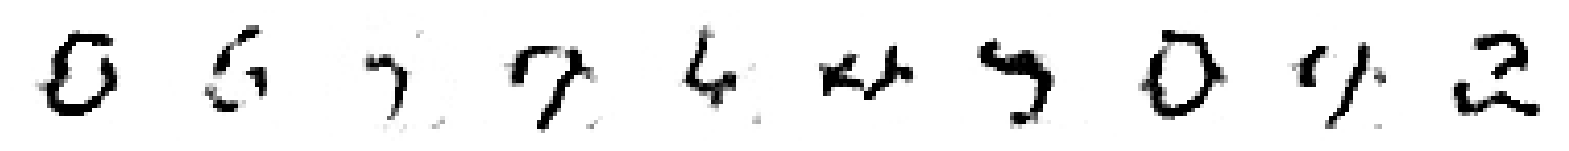


Saved to 07_01_ebm/output/example_img_021.png


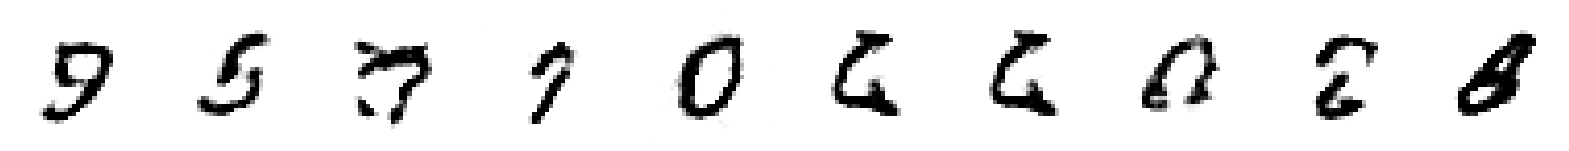

469/469 [==============================] - 275s 586ms/step - loss: 1.3857e-04 - reg: 1.5365e-04 - cdiv: -1.5079e-05 - real: 4.2082e-04 - fake: 4.0574e-04 - val_cdiv: -9.2659 - val_real: 0.0220 - val_fake: -9.2440
Epoch 23/60
469/469 [==============================] - ETA: 0s - loss: -1.2825e-04 - reg: 1.0896e-04 - cdiv: -2.3720e-04 - real: 4.6348e-04 - fake: 2.2628e-04
Saved to 07_01_ebm/output/generated_img_022.png


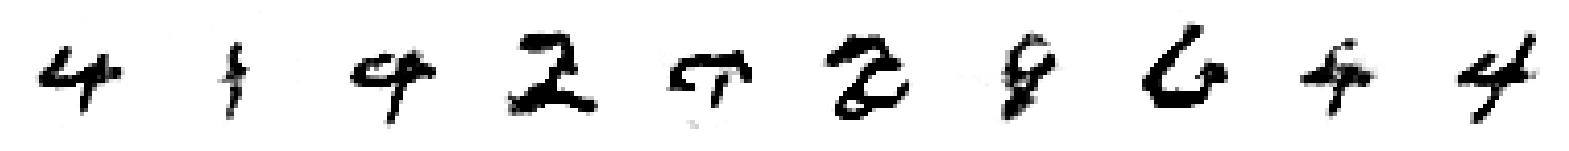


Saved to 07_01_ebm/output/example_img_022.png


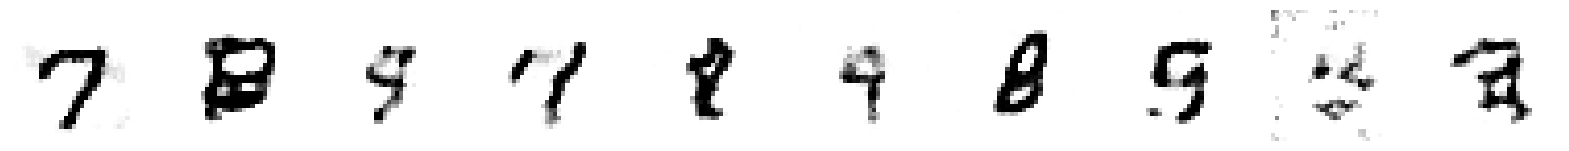

469/469 [==============================] - 272s 580ms/step - loss: -1.2825e-04 - reg: 1.0896e-04 - cdiv: -2.3720e-04 - real: 4.6348e-04 - fake: 2.2628e-04 - val_cdiv: -9.4550 - val_real: 0.0110 - val_fake: -9.4440
Epoch 24/60
469/469 [==============================] - ETA: 0s - loss: 3.3148e-05 - reg: 1.4236e-04 - cdiv: -1.0921e-04 - real: 1.7688e-04 - fake: 6.7670e-05
Saved to 07_01_ebm/output/generated_img_023.png


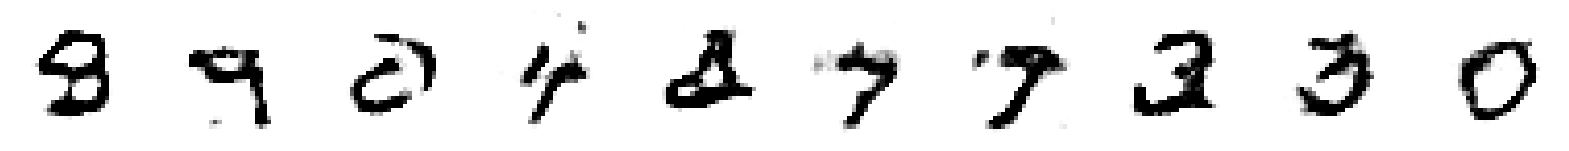


Saved to 07_01_ebm/output/example_img_023.png


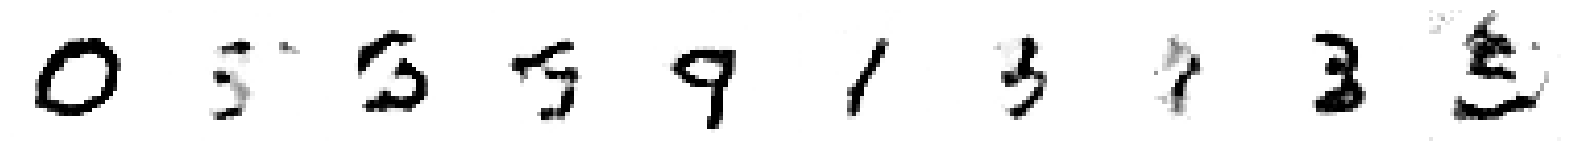

469/469 [==============================] - 275s 586ms/step - loss: 3.3148e-05 - reg: 1.4236e-04 - cdiv: -1.0921e-04 - real: 1.7688e-04 - fake: 6.7670e-05 - val_cdiv: -9.8636 - val_real: 0.0133 - val_fake: -9.8504
Epoch 25/60
469/469 [==============================] - ETA: 0s - loss: 1.0325e-04 - reg: 1.1824e-04 - cdiv: -1.4986e-05 - real: 4.8295e-04 - fake: 4.6797e-04
Saved to 07_01_ebm/output/generated_img_024.png


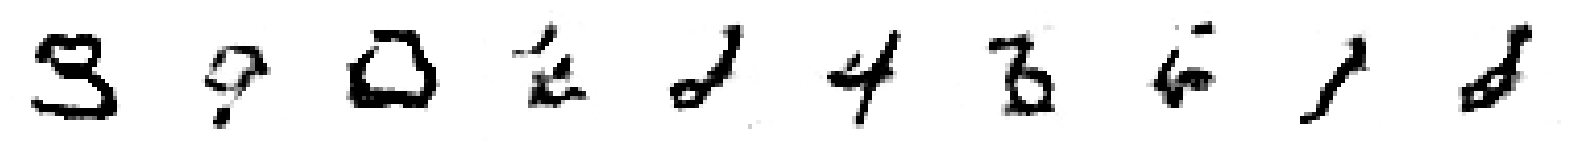


Saved to 07_01_ebm/output/example_img_024.png


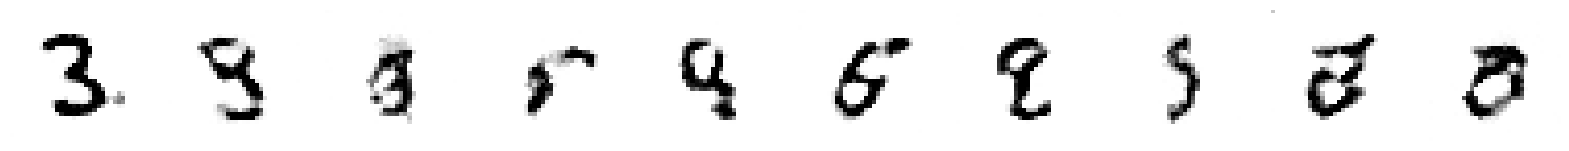

469/469 [==============================] - 274s 584ms/step - loss: 1.0325e-04 - reg: 1.1824e-04 - cdiv: -1.4986e-05 - real: 4.8295e-04 - fake: 4.6797e-04 - val_cdiv: -10.3095 - val_real: 0.0131 - val_fake: -10.2964
Epoch 26/60
469/469 [==============================] - ETA: 0s - loss: -3.2803e-06 - reg: 1.3104e-04 - cdiv: -1.3432e-04 - real: 5.2943e-04 - fake: 3.9511e-04
Saved to 07_01_ebm/output/generated_img_025.png


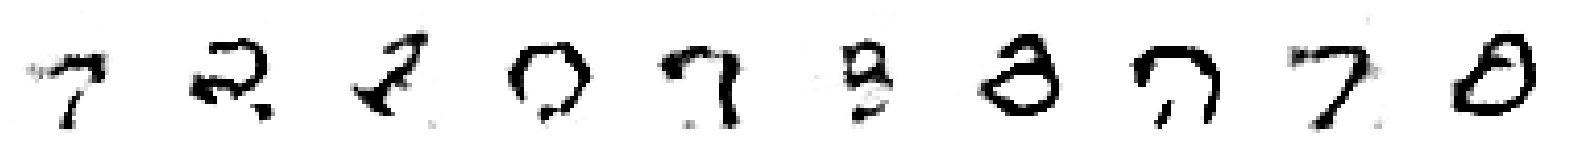


Saved to 07_01_ebm/output/example_img_025.png


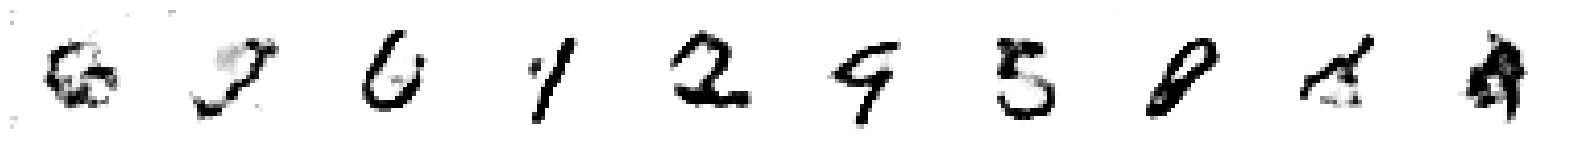

469/469 [==============================] - 276s 588ms/step - loss: -3.2803e-06 - reg: 1.3104e-04 - cdiv: -1.3432e-04 - real: 5.2943e-04 - fake: 3.9511e-04 - val_cdiv: -10.9233 - val_real: 0.0156 - val_fake: -10.9076
Epoch 27/60
469/469 [==============================] - ETA: 0s - loss: 1.1939e-04 - reg: 1.0669e-04 - cdiv: 1.2692e-05 - real: 1.3023e-04 - fake: 1.4293e-04
Saved to 07_01_ebm/output/generated_img_026.png


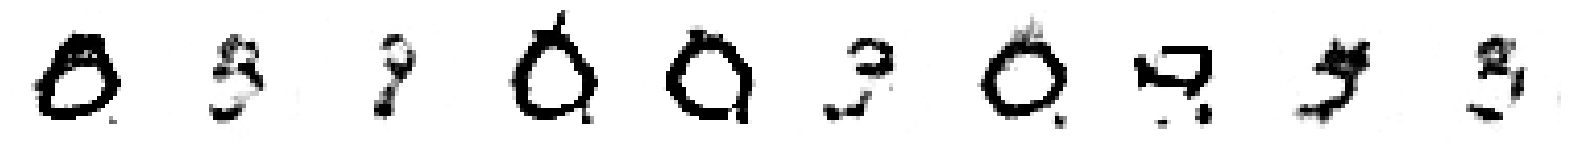


Saved to 07_01_ebm/output/example_img_026.png


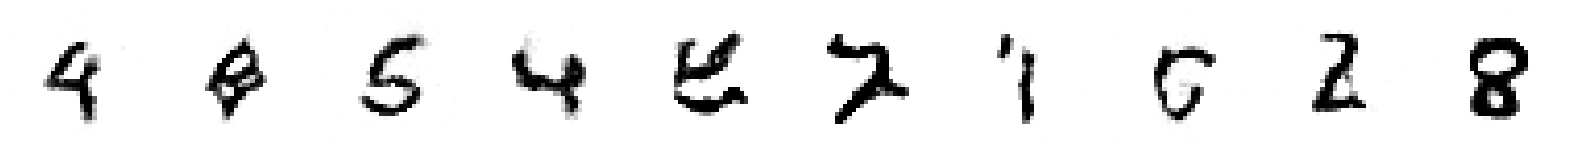

469/469 [==============================] - 276s 589ms/step - loss: 1.1939e-04 - reg: 1.0669e-04 - cdiv: 1.2692e-05 - real: 1.3023e-04 - fake: 1.4293e-04 - val_cdiv: -11.1028 - val_real: 0.0106 - val_fake: -11.0922
Epoch 28/60
469/469 [==============================] - ETA: 0s - loss: 1.0730e-04 - reg: 1.0083e-04 - cdiv: 6.4750e-06 - real: 5.9265e-05 - fake: 6.5740e-05
Saved to 07_01_ebm/output/generated_img_027.png


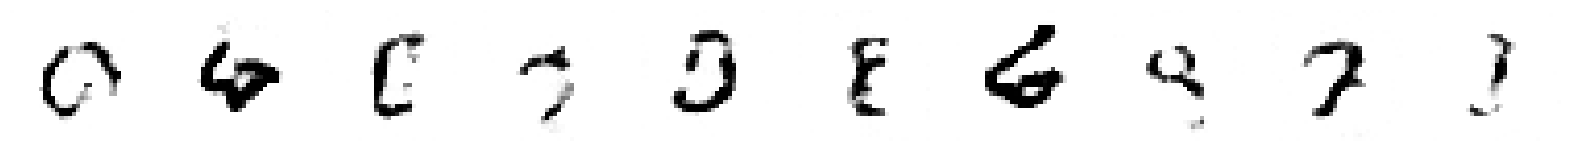


Saved to 07_01_ebm/output/example_img_027.png


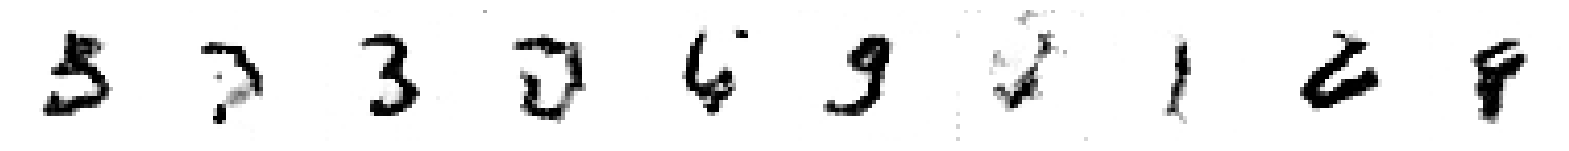

469/469 [==============================] - 275s 586ms/step - loss: 1.0730e-04 - reg: 1.0083e-04 - cdiv: 6.4750e-06 - real: 5.9265e-05 - fake: 6.5740e-05 - val_cdiv: -11.3894 - val_real: 0.0080 - val_fake: -11.3814
Epoch 29/60
469/469 [==============================] - ETA: 0s - loss: 3.9576e-04 - reg: 1.2885e-04 - cdiv: 2.6691e-04 - real: -4.2499e-05 - fake: 2.2441e-04
Saved to 07_01_ebm/output/generated_img_028.png


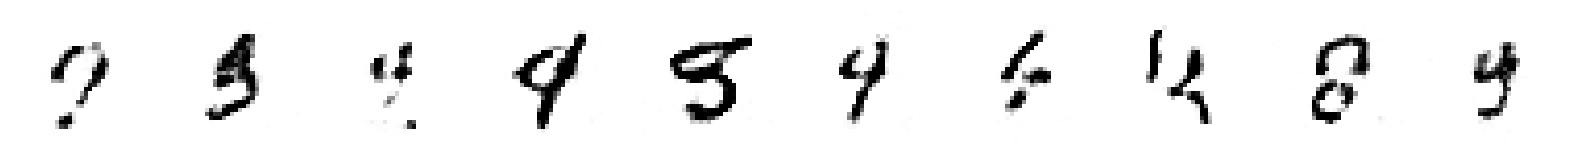


Saved to 07_01_ebm/output/example_img_028.png


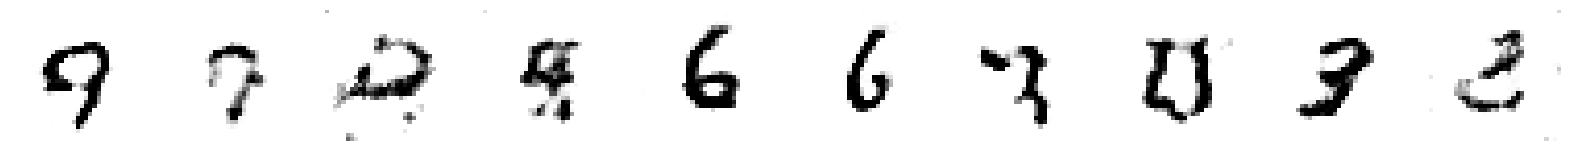

469/469 [==============================] - 271s 578ms/step - loss: 3.9576e-04 - reg: 1.2885e-04 - cdiv: 2.6691e-04 - real: -4.2499e-05 - fake: 2.2441e-04 - val_cdiv: -12.0334 - val_real: 0.0102 - val_fake: -12.0232
Epoch 30/60
469/469 [==============================] - ETA: 0s - loss: -1.4044e-04 - reg: 1.0005e-04 - cdiv: -2.4049e-04 - real: 6.3766e-04 - fake: 3.9717e-04
Saved to 07_01_ebm/output/generated_img_029.png


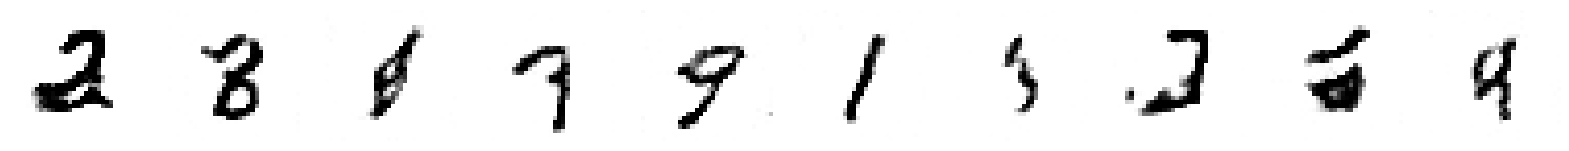


Saved to 07_01_ebm/output/example_img_029.png


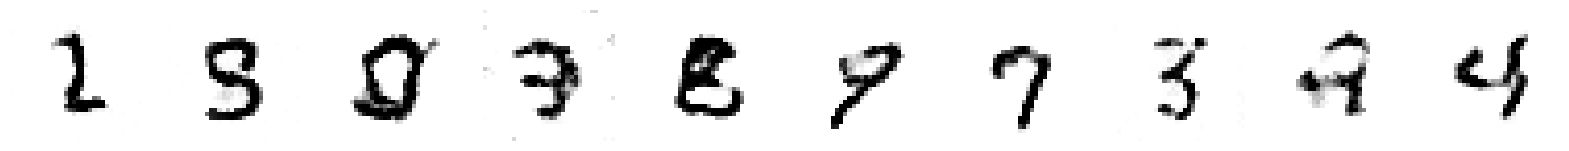

469/469 [==============================] - 267s 568ms/step - loss: -1.4044e-04 - reg: 1.0005e-04 - cdiv: -2.4049e-04 - real: 6.3766e-04 - fake: 3.9717e-04 - val_cdiv: -12.1665 - val_real: 0.0111 - val_fake: -12.1554
Epoch 31/60
469/469 [==============================] - ETA: 0s - loss: 2.5682e-04 - reg: 1.4350e-04 - cdiv: 1.1333e-04 - real: 6.3427e-05 - fake: 1.7675e-04
Saved to 07_01_ebm/output/generated_img_030.png


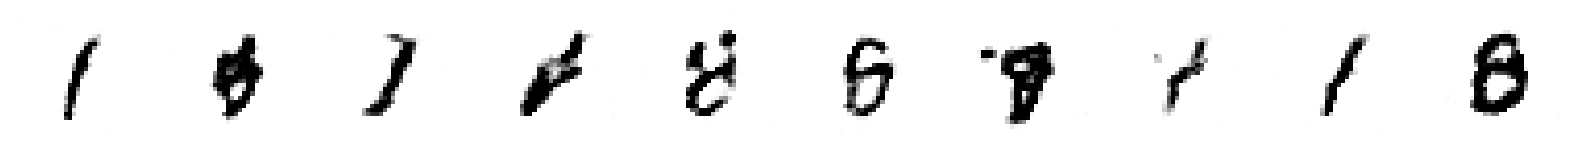


Saved to 07_01_ebm/output/example_img_030.png


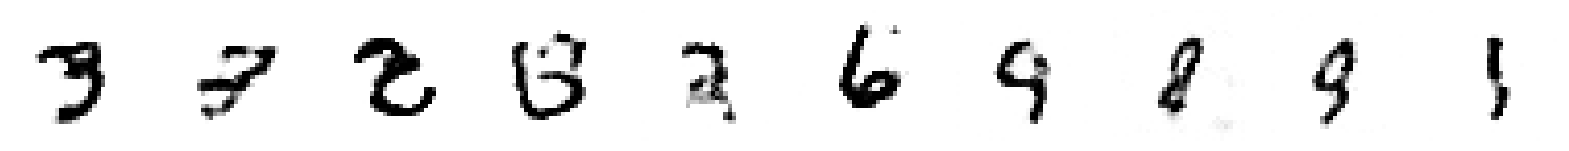

469/469 [==============================] - 268s 571ms/step - loss: 2.5682e-04 - reg: 1.4350e-04 - cdiv: 1.1333e-04 - real: 6.3427e-05 - fake: 1.7675e-04 - val_cdiv: -12.6675 - val_real: 0.0095 - val_fake: -12.6580
Epoch 32/60
469/469 [==============================] - ETA: 0s - loss: 3.4999e-04 - reg: 9.0744e-05 - cdiv: 2.5924e-04 - real: -2.4796e-05 - fake: 2.3445e-04
Saved to 07_01_ebm/output/generated_img_031.png


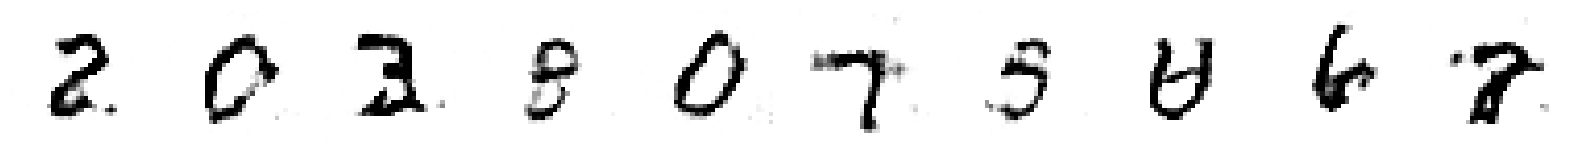


Saved to 07_01_ebm/output/example_img_031.png


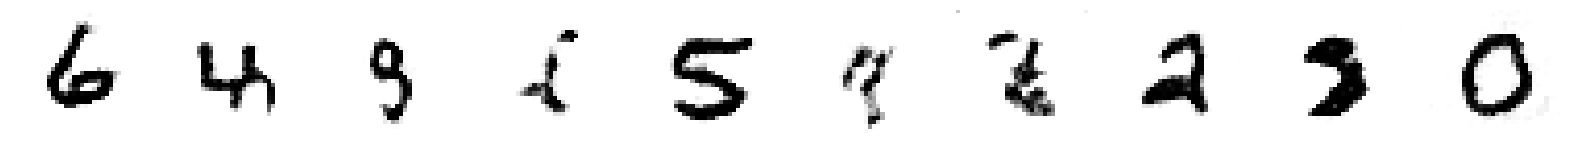

469/469 [==============================] - 266s 568ms/step - loss: 3.4999e-04 - reg: 9.0744e-05 - cdiv: 2.5924e-04 - real: -2.4796e-05 - fake: 2.3445e-04 - val_cdiv: -12.8072 - val_real: 0.0113 - val_fake: -12.7960
Epoch 33/60
469/469 [==============================] - ETA: 0s - loss: -2.6998e-05 - reg: 9.4055e-05 - cdiv: -1.2105e-04 - real: 1.1876e-04 - fake: -2.2933e-06
Saved to 07_01_ebm/output/generated_img_032.png


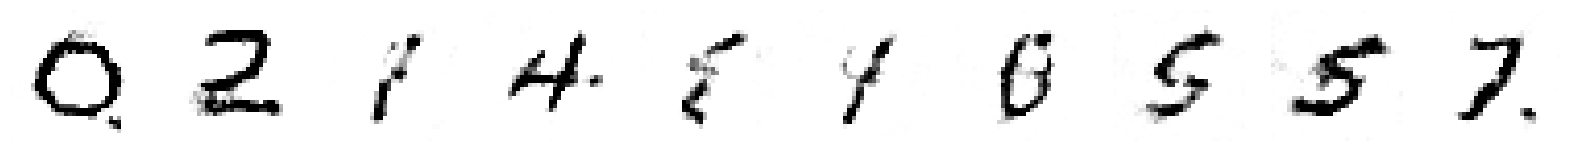


Saved to 07_01_ebm/output/example_img_032.png


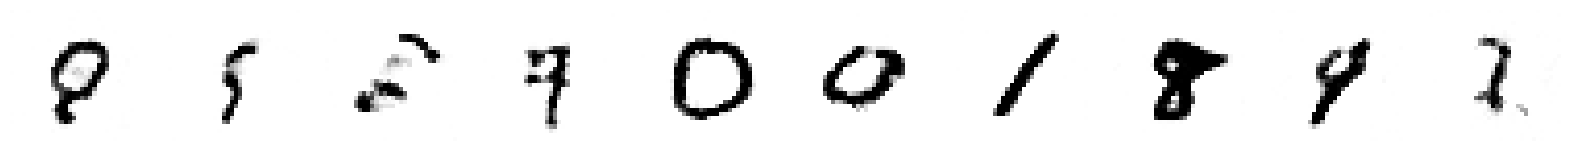

469/469 [==============================] - 267s 570ms/step - loss: -2.6998e-05 - reg: 9.4055e-05 - cdiv: -1.2105e-04 - real: 1.1876e-04 - fake: -2.2933e-06 - val_cdiv: -13.2778 - val_real: 0.0132 - val_fake: -13.2645
Epoch 34/60
469/469 [==============================] - ETA: 0s - loss: 1.9322e-04 - reg: 1.0561e-04 - cdiv: 8.7606e-05 - real: 8.7626e-05 - fake: 1.7523e-04
Saved to 07_01_ebm/output/generated_img_033.png


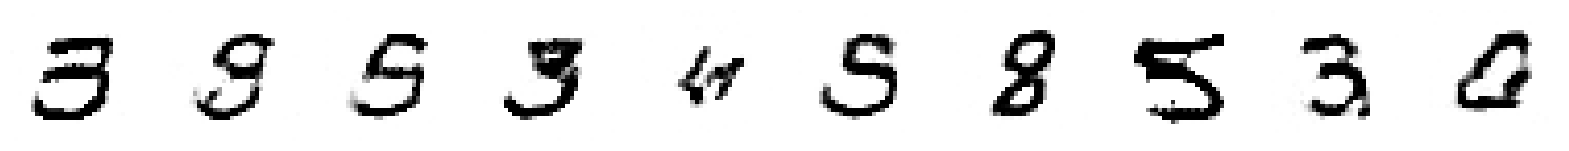


Saved to 07_01_ebm/output/example_img_033.png


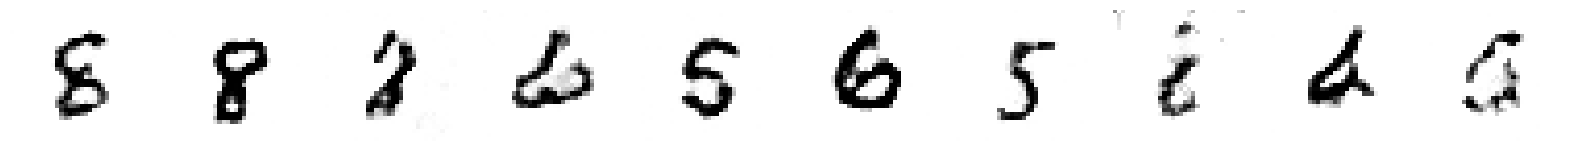

469/469 [==============================] - 267s 569ms/step - loss: 1.9322e-04 - reg: 1.0561e-04 - cdiv: 8.7606e-05 - real: 8.7626e-05 - fake: 1.7523e-04 - val_cdiv: -13.6799 - val_real: 0.0082 - val_fake: -13.6717
Epoch 35/60
469/469 [==============================] - ETA: 0s - loss: 1.1796e-04 - reg: 8.5518e-05 - cdiv: 3.2438e-05 - real: 1.8225e-04 - fake: 2.1469e-04
Saved to 07_01_ebm/output/generated_img_034.png


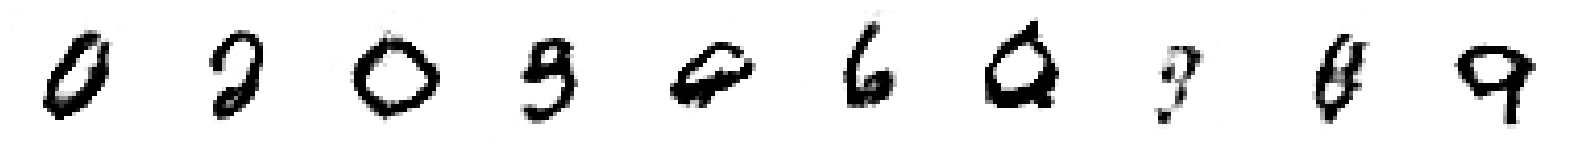


Saved to 07_01_ebm/output/example_img_034.png


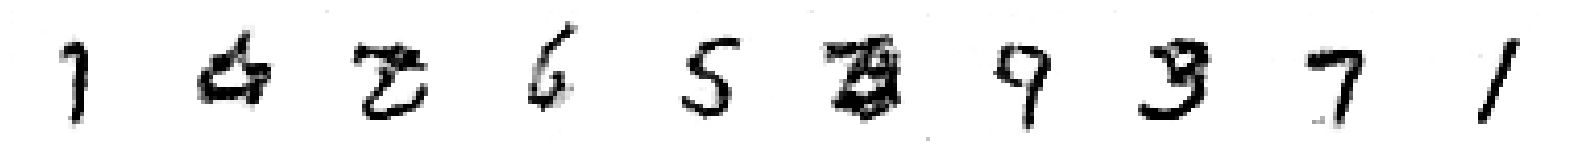

469/469 [==============================] - 268s 572ms/step - loss: 1.1796e-04 - reg: 8.5518e-05 - cdiv: 3.2438e-05 - real: 1.8225e-04 - fake: 2.1469e-04 - val_cdiv: -13.7940 - val_real: 0.0053 - val_fake: -13.7888
Epoch 36/60
469/469 [==============================] - ETA: 0s - loss: 3.7325e-04 - reg: 1.2333e-04 - cdiv: 2.4992e-04 - real: -1.3670e-04 - fake: 1.1322e-04
Saved to 07_01_ebm/output/generated_img_035.png


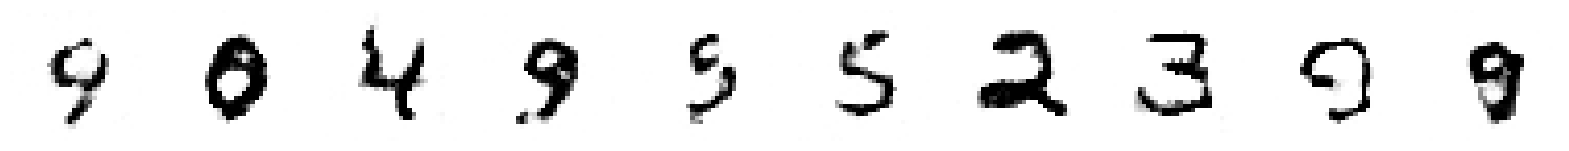


Saved to 07_01_ebm/output/example_img_035.png


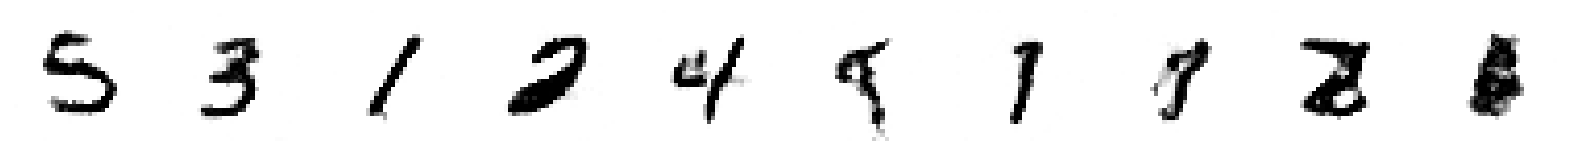

469/469 [==============================] - 266s 567ms/step - loss: 3.7325e-04 - reg: 1.2333e-04 - cdiv: 2.4992e-04 - real: -1.3670e-04 - fake: 1.1322e-04 - val_cdiv: -13.8200 - val_real: 0.0102 - val_fake: -13.8098
Epoch 37/60
469/469 [==============================] - ETA: 0s - loss: -1.9370e-04 - reg: 9.9240e-05 - cdiv: -2.9294e-04 - real: 5.1377e-04 - fake: 2.2083e-04
Saved to 07_01_ebm/output/generated_img_036.png


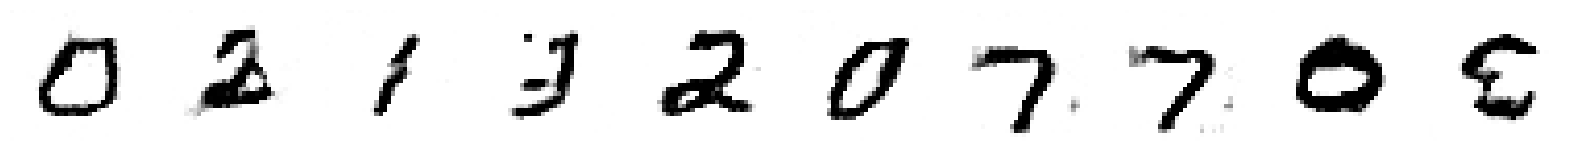


Saved to 07_01_ebm/output/example_img_036.png


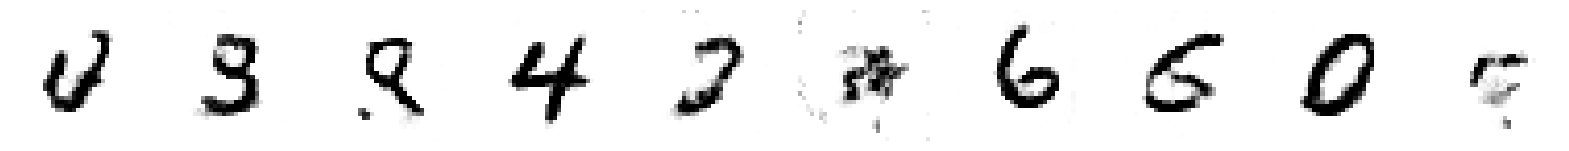

469/469 [==============================] - 269s 573ms/step - loss: -1.9370e-04 - reg: 9.9240e-05 - cdiv: -2.9294e-04 - real: 5.1377e-04 - fake: 2.2083e-04 - val_cdiv: -14.4952 - val_real: 0.0065 - val_fake: -14.4886
Epoch 38/60
469/469 [==============================] - ETA: 0s - loss: 3.1428e-04 - reg: 1.0186e-04 - cdiv: 2.1243e-04 - real: 1.3398e-04 - fake: 3.4641e-04
Saved to 07_01_ebm/output/generated_img_037.png


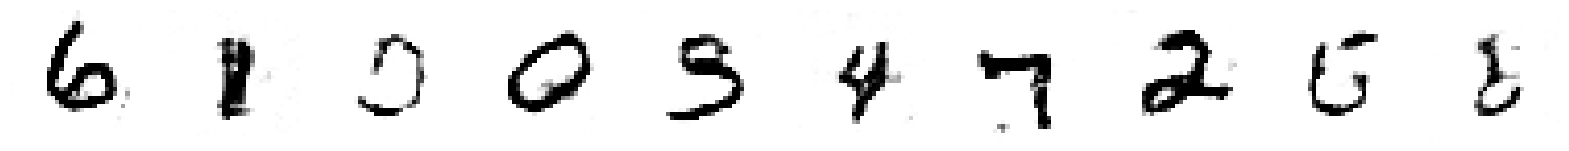


Saved to 07_01_ebm/output/example_img_037.png


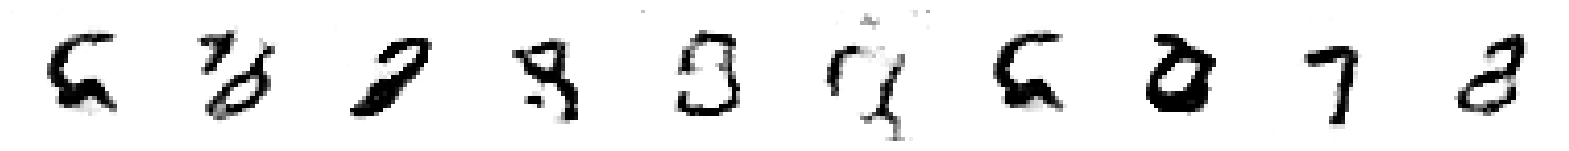

469/469 [==============================] - 268s 572ms/step - loss: 3.1428e-04 - reg: 1.0186e-04 - cdiv: 2.1243e-04 - real: 1.3398e-04 - fake: 3.4641e-04 - val_cdiv: -14.6827 - val_real: 0.0079 - val_fake: -14.6748
Epoch 39/60
469/469 [==============================] - ETA: 0s - loss: 2.8566e-04 - reg: 9.9826e-05 - cdiv: 1.8583e-04 - real: 1.0474e-05 - fake: 1.9631e-04
Saved to 07_01_ebm/output/generated_img_038.png


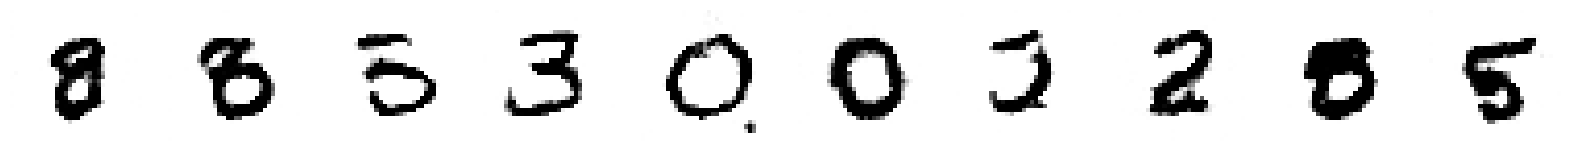


Saved to 07_01_ebm/output/example_img_038.png


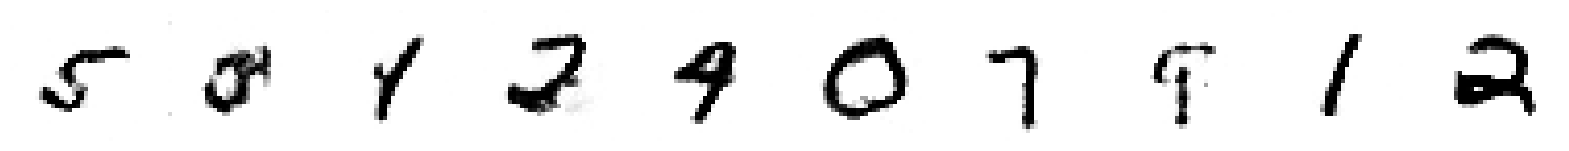

469/469 [==============================] - 267s 569ms/step - loss: 2.8566e-04 - reg: 9.9826e-05 - cdiv: 1.8583e-04 - real: 1.0474e-05 - fake: 1.9631e-04 - val_cdiv: -14.8758 - val_real: 0.0036 - val_fake: -14.8722
Epoch 40/60
469/469 [==============================] - ETA: 0s - loss: -4.5424e-06 - reg: 9.9503e-05 - cdiv: -1.0405e-04 - real: 9.1190e-05 - fake: -1.2855e-05
Saved to 07_01_ebm/output/generated_img_039.png


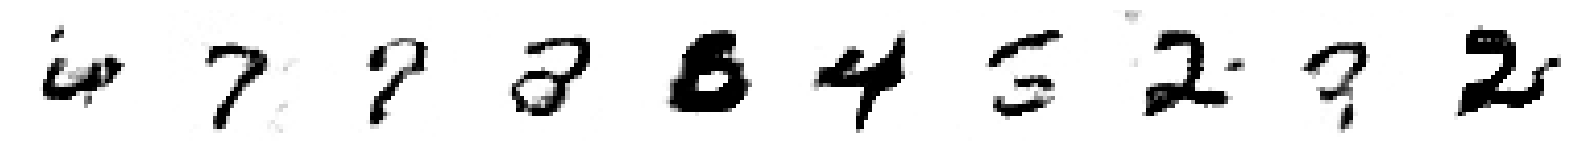


Saved to 07_01_ebm/output/example_img_039.png


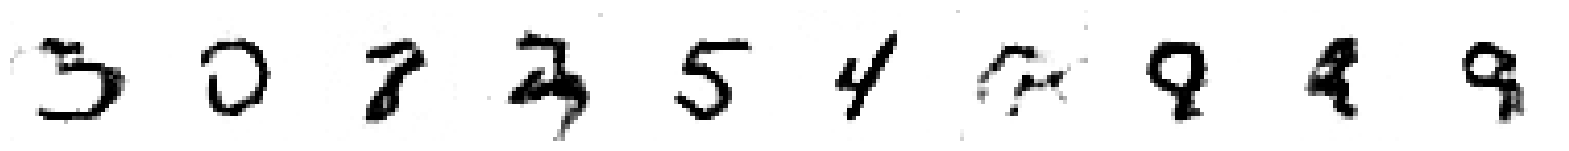

469/469 [==============================] - 269s 573ms/step - loss: -4.5424e-06 - reg: 9.9503e-05 - cdiv: -1.0405e-04 - real: 9.1190e-05 - fake: -1.2855e-05 - val_cdiv: -15.1069 - val_real: 0.0084 - val_fake: -15.0986
Epoch 41/60
469/469 [==============================] - ETA: 0s - loss: 3.0588e-04 - reg: 9.3325e-05 - cdiv: 2.1255e-04 - real: 1.6029e-04 - fake: 3.7284e-04
Saved to 07_01_ebm/output/generated_img_040.png


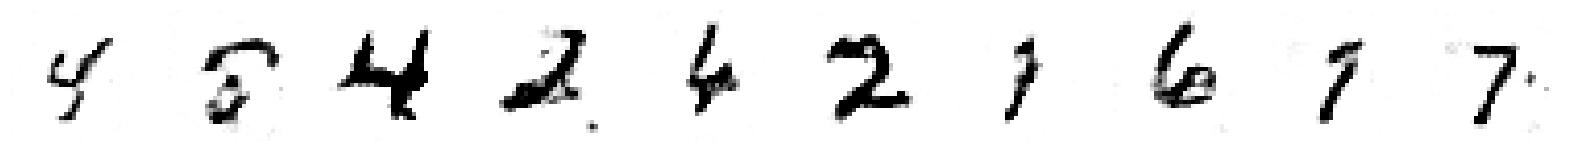


Saved to 07_01_ebm/output/example_img_040.png


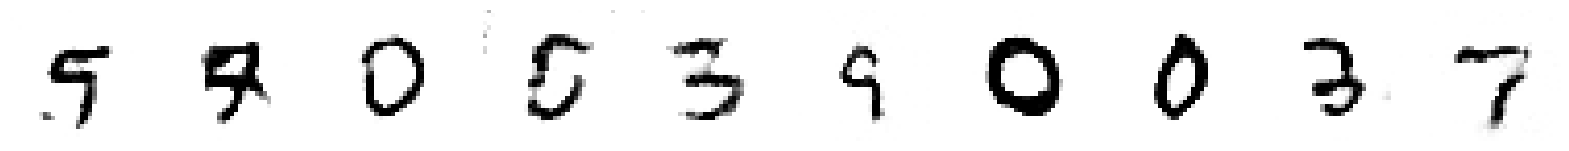

469/469 [==============================] - 268s 572ms/step - loss: 3.0588e-04 - reg: 9.3325e-05 - cdiv: 2.1255e-04 - real: 1.6029e-04 - fake: 3.7284e-04 - val_cdiv: -15.3726 - val_real: 0.0077 - val_fake: -15.3648
Epoch 42/60
469/469 [==============================] - ETA: 0s - loss: 8.2888e-05 - reg: 1.0476e-04 - cdiv: -2.1877e-05 - real: 1.1049e-05 - fake: -1.0829e-05
Saved to 07_01_ebm/output/generated_img_041.png


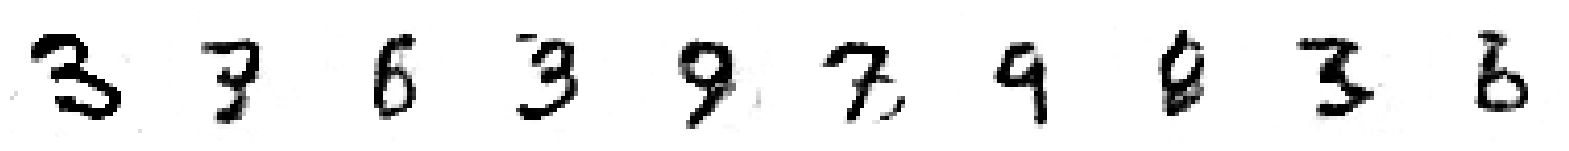


Saved to 07_01_ebm/output/example_img_041.png


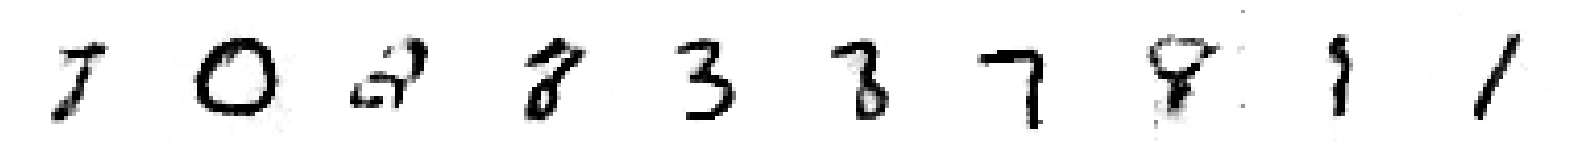

469/469 [==============================] - 268s 571ms/step - loss: 8.2888e-05 - reg: 1.0476e-04 - cdiv: -2.1877e-05 - real: 1.1049e-05 - fake: -1.0829e-05 - val_cdiv: -15.4687 - val_real: 0.0039 - val_fake: -15.4648
Epoch 43/60
469/469 [==============================] - ETA: 0s - loss: 2.5861e-04 - reg: 8.9919e-05 - cdiv: 1.6869e-04 - real: 3.0553e-04 - fake: 4.7422e-04
Saved to 07_01_ebm/output/generated_img_042.png


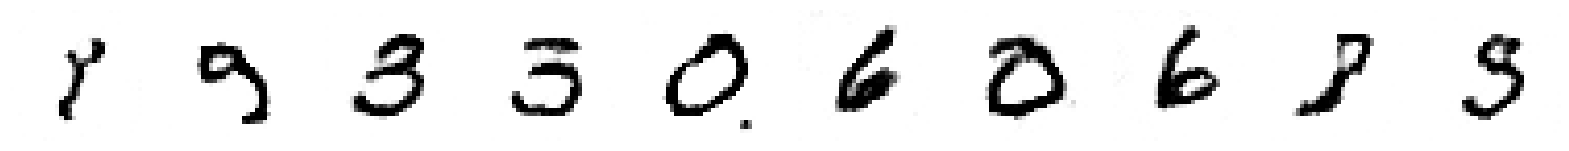


Saved to 07_01_ebm/output/example_img_042.png


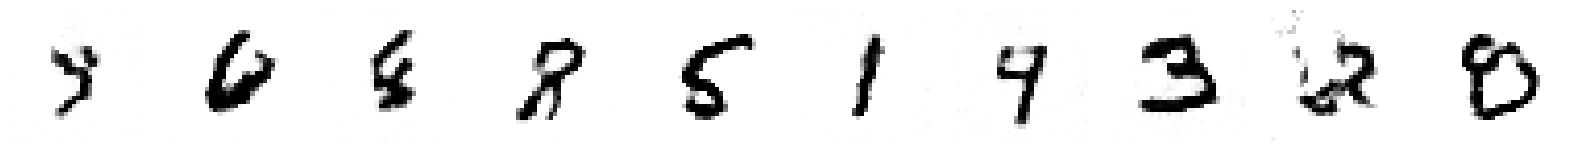

469/469 [==============================] - 275s 587ms/step - loss: 2.5861e-04 - reg: 8.9919e-05 - cdiv: 1.6869e-04 - real: 3.0553e-04 - fake: 4.7422e-04 - val_cdiv: -15.8667 - val_real: -0.0017 - val_fake: -15.8684
Epoch 44/60
469/469 [==============================] - ETA: 0s - loss: 1.9448e-04 - reg: 8.0379e-05 - cdiv: 1.1411e-04 - real: -1.7356e-04 - fake: -5.9455e-05
Saved to 07_01_ebm/output/generated_img_043.png


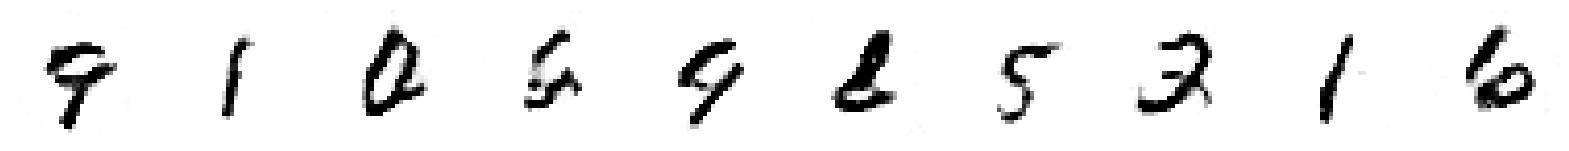


Saved to 07_01_ebm/output/example_img_043.png


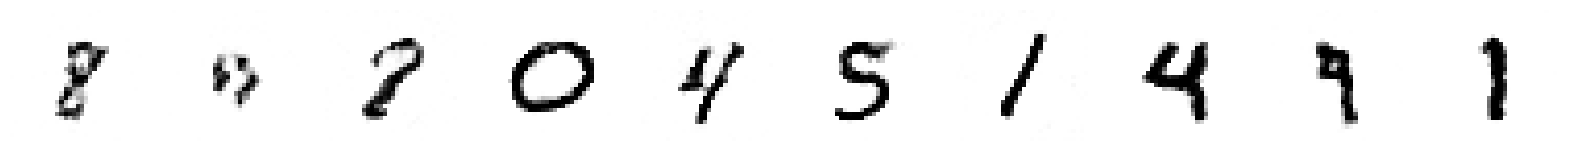

469/469 [==============================] - 273s 582ms/step - loss: 1.9448e-04 - reg: 8.0379e-05 - cdiv: 1.1411e-04 - real: -1.7356e-04 - fake: -5.9455e-05 - val_cdiv: -16.1190 - val_real: 0.0068 - val_fake: -16.1122
Epoch 45/60
469/469 [==============================] - ETA: 0s - loss: 2.2099e-04 - reg: 1.1277e-04 - cdiv: 1.0822e-04 - real: 1.0204e-04 - fake: 2.1025e-04
Saved to 07_01_ebm/output/generated_img_044.png


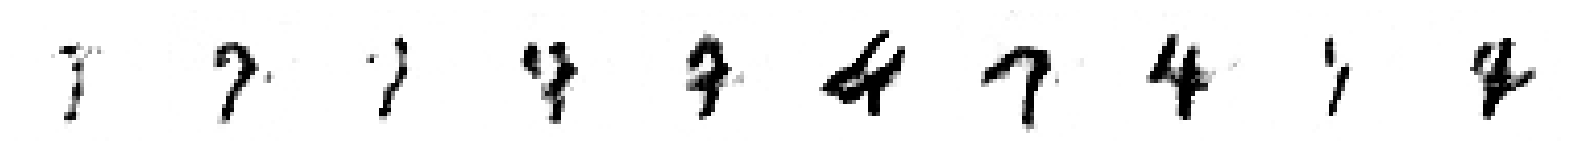


Saved to 07_01_ebm/output/example_img_044.png


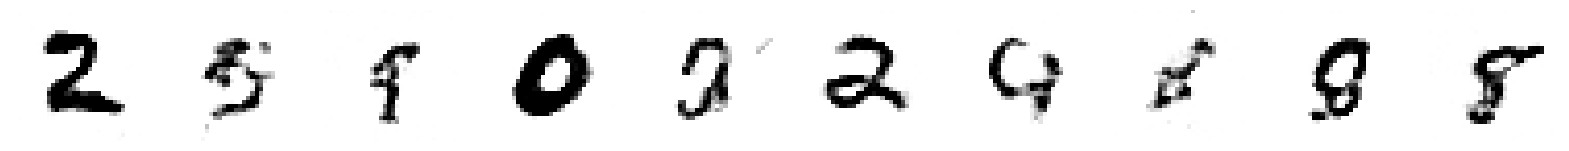

469/469 [==============================] - 276s 588ms/step - loss: 2.2099e-04 - reg: 1.1277e-04 - cdiv: 1.0822e-04 - real: 1.0204e-04 - fake: 2.1025e-04 - val_cdiv: -16.3584 - val_real: 0.0095 - val_fake: -16.3488
Epoch 46/60
469/469 [==============================] - ETA: 0s - loss: 1.6480e-04 - reg: 9.0364e-05 - cdiv: 7.4432e-05 - real: 4.1651e-05 - fake: 1.1608e-04
Saved to 07_01_ebm/output/generated_img_045.png


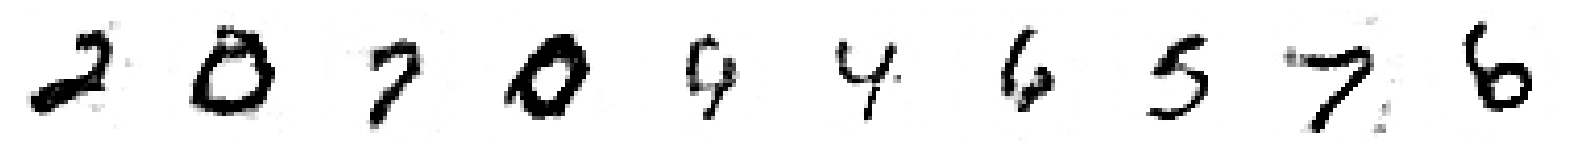


Saved to 07_01_ebm/output/example_img_045.png


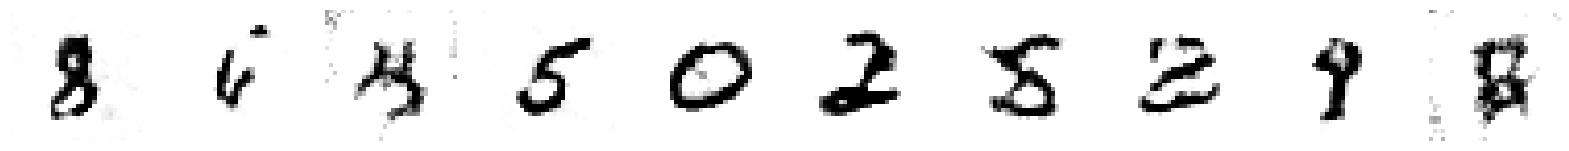

469/469 [==============================] - 274s 584ms/step - loss: 1.6480e-04 - reg: 9.0364e-05 - cdiv: 7.4432e-05 - real: 4.1651e-05 - fake: 1.1608e-04 - val_cdiv: -16.3456 - val_real: 0.0053 - val_fake: -16.3403
Epoch 47/60
469/469 [==============================] - ETA: 0s - loss: 9.0763e-05 - reg: 9.2140e-05 - cdiv: -1.3764e-06 - real: 1.6121e-04 - fake: 1.5984e-04
Saved to 07_01_ebm/output/generated_img_046.png


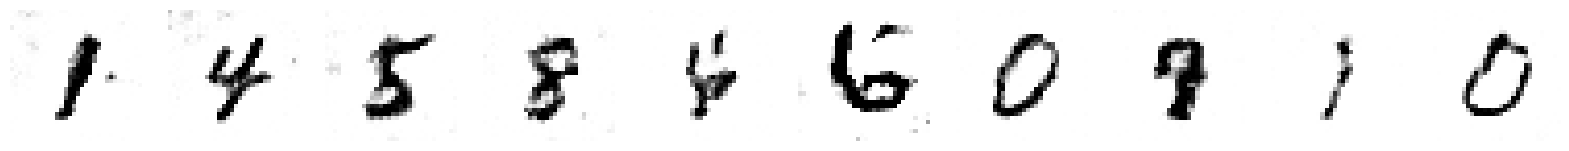


Saved to 07_01_ebm/output/example_img_046.png


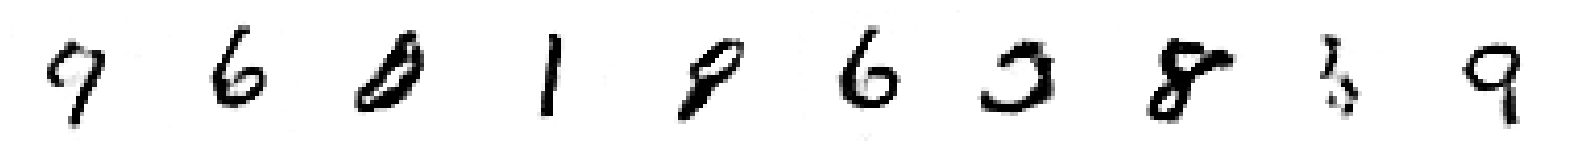

469/469 [==============================] - 275s 586ms/step - loss: 9.0763e-05 - reg: 9.2140e-05 - cdiv: -1.3764e-06 - real: 1.6121e-04 - fake: 1.5984e-04 - val_cdiv: -16.4470 - val_real: 0.0055 - val_fake: -16.4416
Epoch 48/60
469/469 [==============================] - ETA: 0s - loss: 2.0842e-04 - reg: 9.5040e-05 - cdiv: 1.1338e-04 - real: 6.5529e-05 - fake: 1.7891e-04
Saved to 07_01_ebm/output/generated_img_047.png


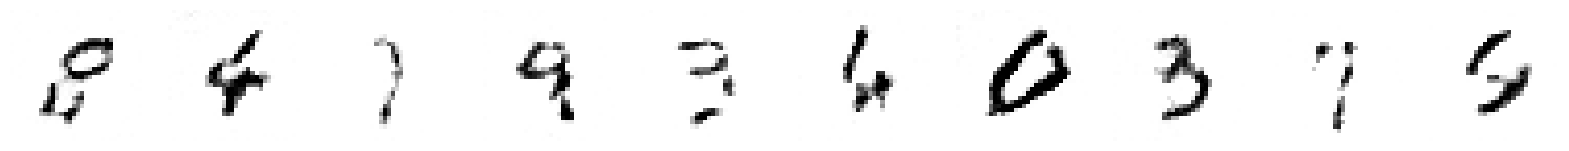


Saved to 07_01_ebm/output/example_img_047.png


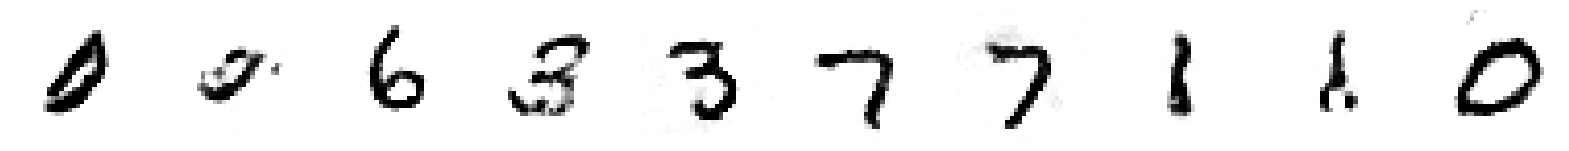

469/469 [==============================] - 275s 586ms/step - loss: 2.0842e-04 - reg: 9.5040e-05 - cdiv: 1.1338e-04 - real: 6.5529e-05 - fake: 1.7891e-04 - val_cdiv: -16.4416 - val_real: 0.0091 - val_fake: -16.4324
Epoch 49/60
469/469 [==============================] - ETA: 0s - loss: 1.2960e-04 - reg: 1.5839e-04 - cdiv: -2.8783e-05 - real: -1.7421e-04 - fake: -2.0299e-04
Saved to 07_01_ebm/output/generated_img_048.png


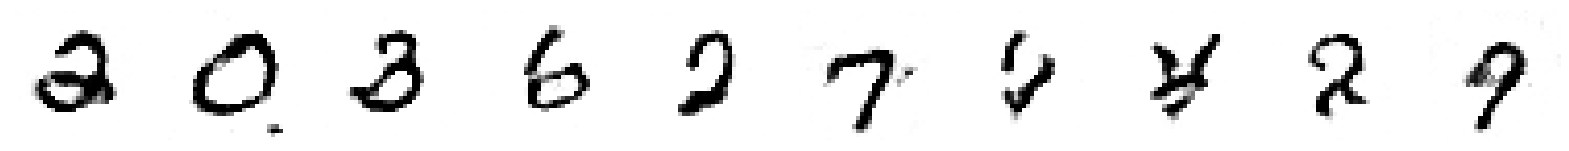


Saved to 07_01_ebm/output/example_img_048.png


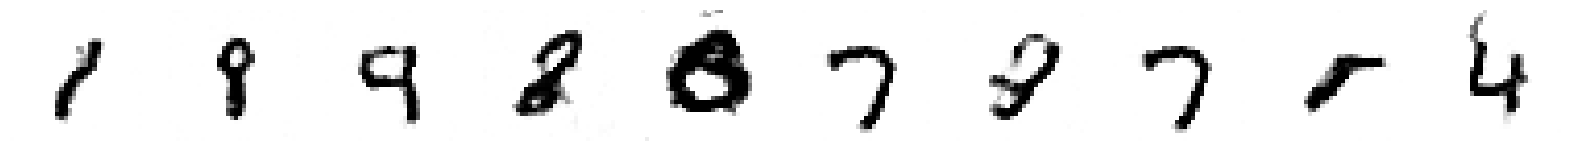

469/469 [==============================] - 272s 580ms/step - loss: 1.2960e-04 - reg: 1.5839e-04 - cdiv: -2.8783e-05 - real: -1.7421e-04 - fake: -2.0299e-04 - val_cdiv: -16.6639 - val_real: 0.0013 - val_fake: -16.6627
Epoch 50/60
469/469 [==============================] - ETA: 0s - loss: 1.5750e-04 - reg: 1.0537e-04 - cdiv: 5.2126e-05 - real: 2.9542e-04 - fake: 3.4755e-04
Saved to 07_01_ebm/output/generated_img_049.png


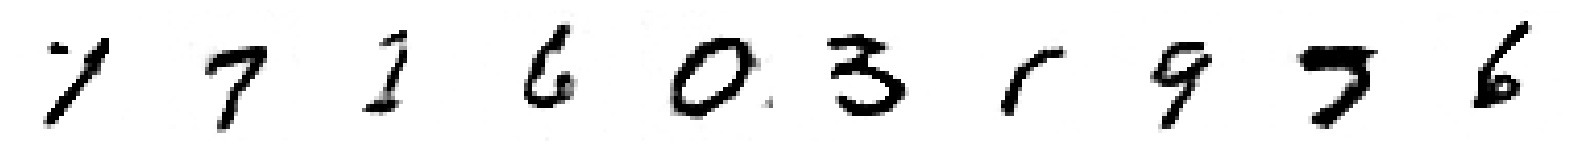


Saved to 07_01_ebm/output/example_img_049.png


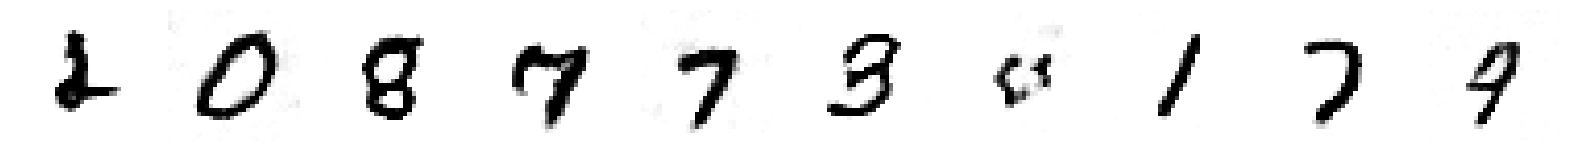

469/469 [==============================] - 269s 573ms/step - loss: 1.5750e-04 - reg: 1.0537e-04 - cdiv: 5.2126e-05 - real: 2.9542e-04 - fake: 3.4755e-04 - val_cdiv: -16.7387 - val_real: -0.0057 - val_fake: -16.7444
Epoch 51/60
469/469 [==============================] - ETA: 0s - loss: 1.3548e-04 - reg: 9.5269e-05 - cdiv: 4.0210e-05 - real: 3.1378e-04 - fake: 3.5399e-04
Saved to 07_01_ebm/output/generated_img_050.png


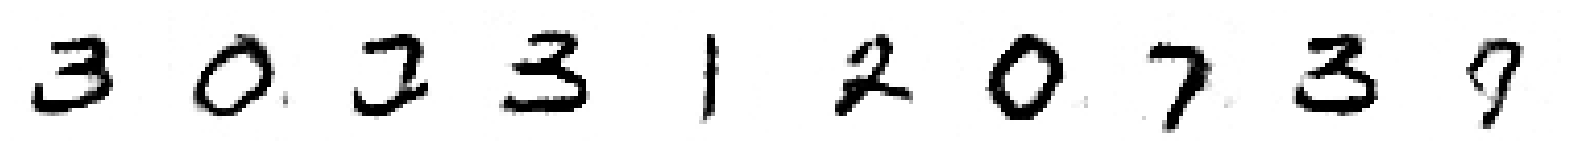


Saved to 07_01_ebm/output/example_img_050.png


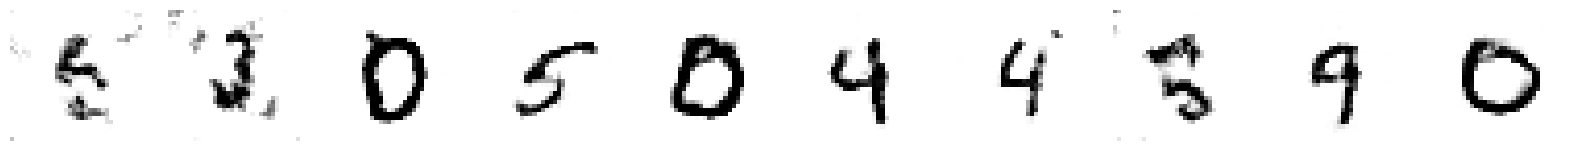

469/469 [==============================] - 268s 570ms/step - loss: 1.3548e-04 - reg: 9.5269e-05 - cdiv: 4.0210e-05 - real: 3.1378e-04 - fake: 3.5399e-04 - val_cdiv: -17.0157 - val_real: -1.3680e-04 - val_fake: -17.0159
Epoch 52/60
469/469 [==============================] - ETA: 0s - loss: 3.0141e-04 - reg: 1.3169e-04 - cdiv: 1.6972e-04 - real: 8.5227e-06 - fake: 1.7824e-04
Saved to 07_01_ebm/output/generated_img_051.png


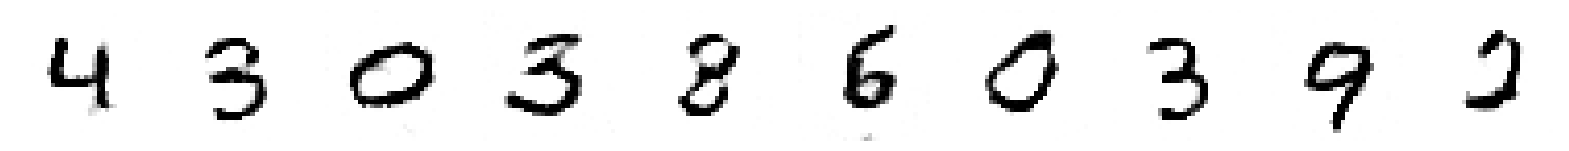


Saved to 07_01_ebm/output/example_img_051.png


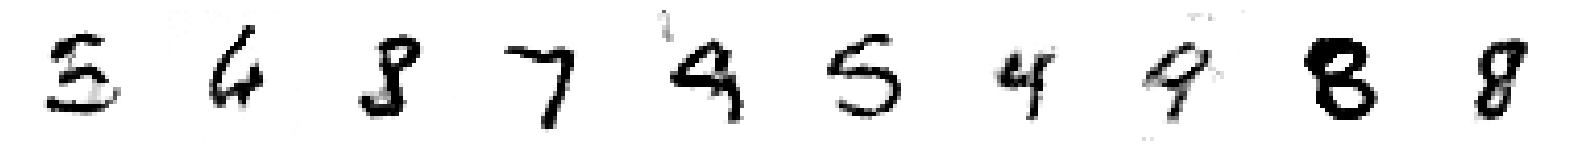

469/469 [==============================] - 270s 576ms/step - loss: 3.0141e-04 - reg: 1.3169e-04 - cdiv: 1.6972e-04 - real: 8.5227e-06 - fake: 1.7824e-04 - val_cdiv: -16.9332 - val_real: -0.0049 - val_fake: -16.9381
Epoch 53/60
469/469 [==============================] - ETA: 0s - loss: 2.4674e-04 - reg: 8.4052e-05 - cdiv: 1.6268e-04 - real: 5.4317e-05 - fake: 2.1700e-04
Saved to 07_01_ebm/output/generated_img_052.png


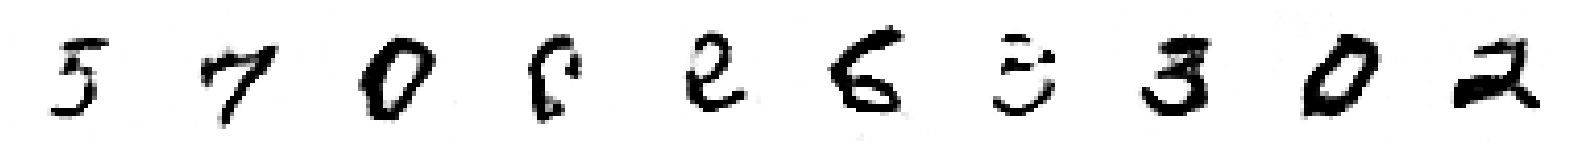


Saved to 07_01_ebm/output/example_img_052.png


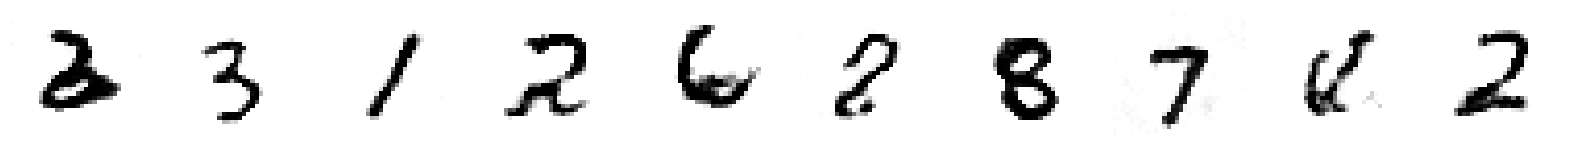

469/469 [==============================] - 270s 576ms/step - loss: 2.4674e-04 - reg: 8.4052e-05 - cdiv: 1.6268e-04 - real: 5.4317e-05 - fake: 2.1700e-04 - val_cdiv: -17.2786 - val_real: 0.0038 - val_fake: -17.2748
Epoch 54/60
469/469 [==============================] - ETA: 0s - loss: 9.0757e-05 - reg: 9.3941e-05 - cdiv: -3.1839e-06 - real: -1.2320e-04 - fake: -1.2638e-04
Saved to 07_01_ebm/output/generated_img_053.png


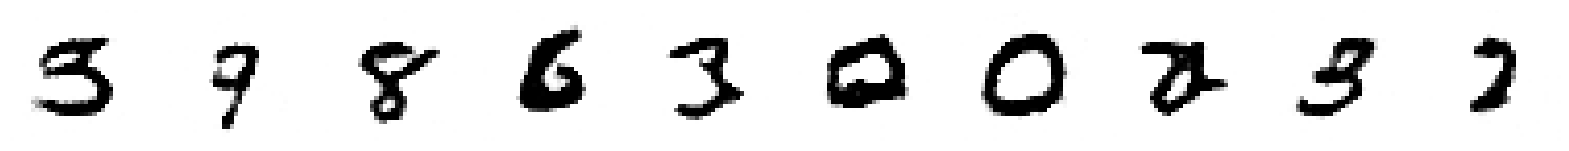


Saved to 07_01_ebm/output/example_img_053.png


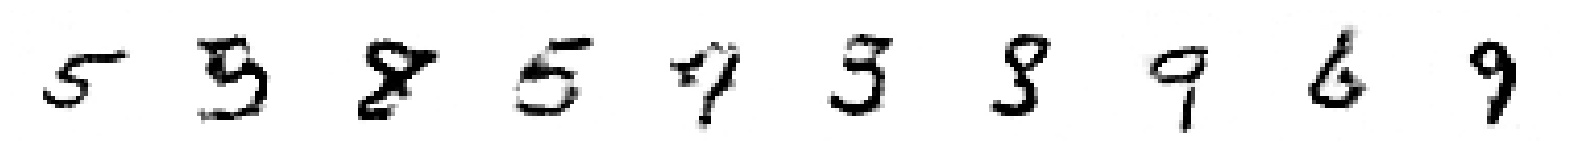

469/469 [==============================] - 273s 581ms/step - loss: 9.0757e-05 - reg: 9.3941e-05 - cdiv: -3.1839e-06 - real: -1.2320e-04 - fake: -1.2638e-04 - val_cdiv: -17.2896 - val_real: -0.0066 - val_fake: -17.2962
Epoch 55/60
469/469 [==============================] - ETA: 0s - loss: 6.7904e-05 - reg: 1.1329e-04 - cdiv: -4.5382e-05 - real: 3.6990e-04 - fake: 3.2452e-04
Saved to 07_01_ebm/output/generated_img_054.png


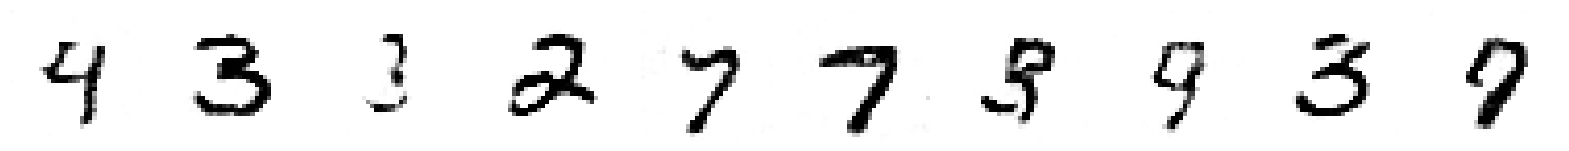


Saved to 07_01_ebm/output/example_img_054.png


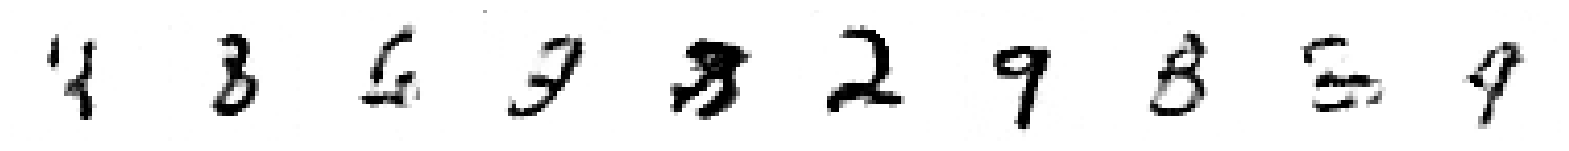

469/469 [==============================] - 271s 578ms/step - loss: 6.7904e-05 - reg: 1.1329e-04 - cdiv: -4.5382e-05 - real: 3.6990e-04 - fake: 3.2452e-04 - val_cdiv: -18.0149 - val_real: -0.0026 - val_fake: -18.0175
Epoch 56/60
469/469 [==============================] - ETA: 0s - loss: 1.9524e-04 - reg: 1.5773e-04 - cdiv: 3.7511e-05 - real: 7.6461e-05 - fake: 1.1397e-04
Saved to 07_01_ebm/output/generated_img_055.png


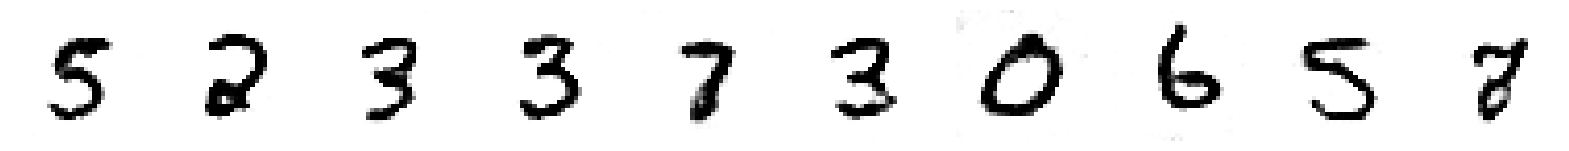


Saved to 07_01_ebm/output/example_img_055.png


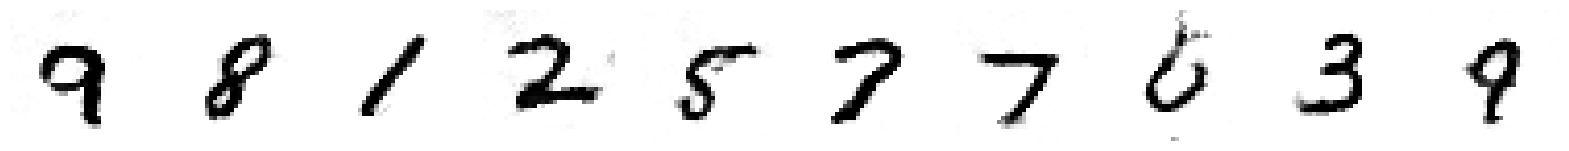

469/469 [==============================] - 272s 580ms/step - loss: 1.9524e-04 - reg: 1.5773e-04 - cdiv: 3.7511e-05 - real: 7.6461e-05 - fake: 1.1397e-04 - val_cdiv: -17.9854 - val_real: -0.0082 - val_fake: -17.9936
Epoch 57/60
469/469 [==============================] - ETA: 0s - loss: 2.1307e-04 - reg: 9.0657e-05 - cdiv: 1.2241e-04 - real: -2.6028e-05 - fake: 9.6387e-05
Saved to 07_01_ebm/output/generated_img_056.png


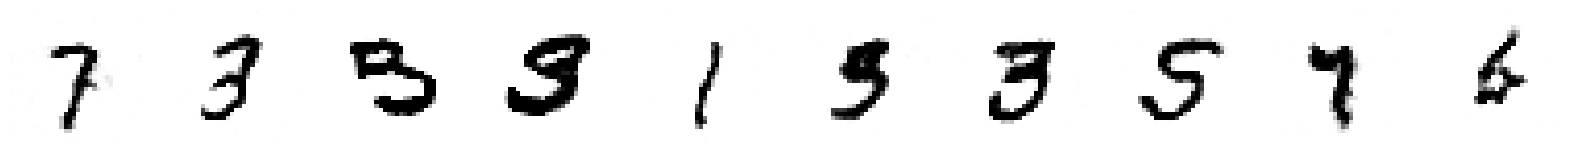


Saved to 07_01_ebm/output/example_img_056.png


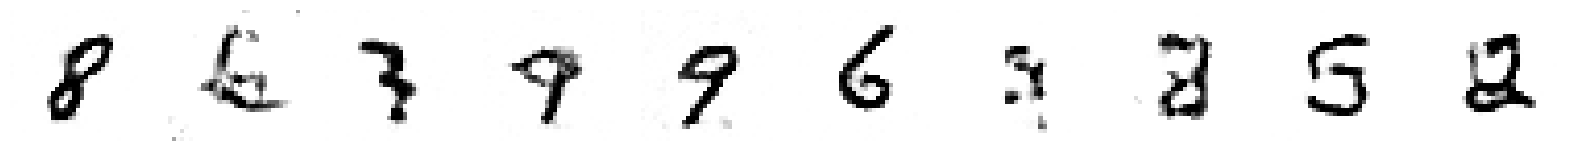

469/469 [==============================] - 272s 579ms/step - loss: 2.1307e-04 - reg: 9.0657e-05 - cdiv: 1.2241e-04 - real: -2.6028e-05 - fake: 9.6387e-05 - val_cdiv: -17.9324 - val_real: -0.0033 - val_fake: -17.9357
Epoch 58/60
469/469 [==============================] - ETA: 0s - loss: 2.2695e-04 - reg: 1.1911e-04 - cdiv: 1.0784e-04 - real: 5.9968e-05 - fake: 1.6781e-04
Saved to 07_01_ebm/output/generated_img_057.png


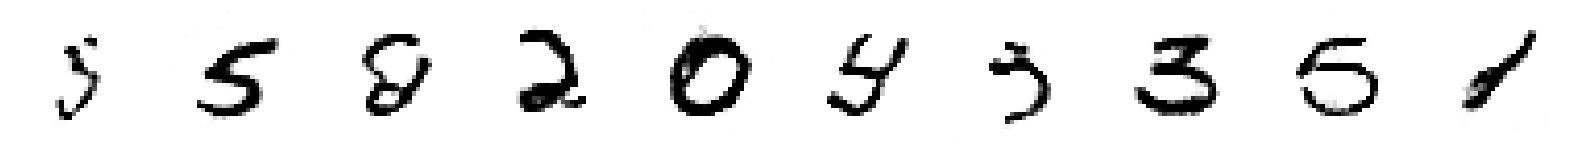


Saved to 07_01_ebm/output/example_img_057.png


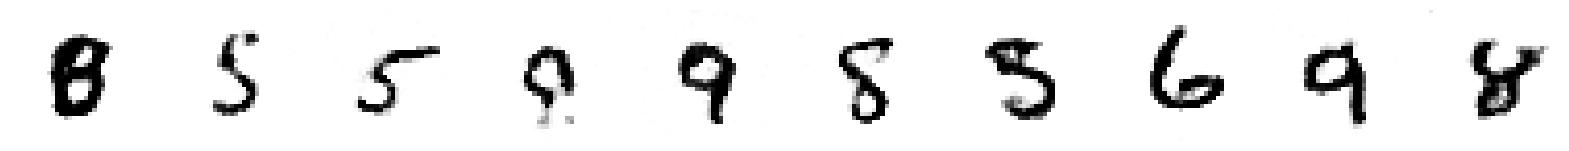

469/469 [==============================] - 272s 580ms/step - loss: 2.2695e-04 - reg: 1.1911e-04 - cdiv: 1.0784e-04 - real: 5.9968e-05 - fake: 1.6781e-04 - val_cdiv: -17.9712 - val_real: -0.0015 - val_fake: -17.9728
Epoch 59/60
469/469 [==============================] - ETA: 0s - loss: -7.7328e-05 - reg: 1.0873e-04 - cdiv: -1.8606e-04 - real: 3.0224e-04 - fake: 1.1617e-04
Saved to 07_01_ebm/output/generated_img_058.png


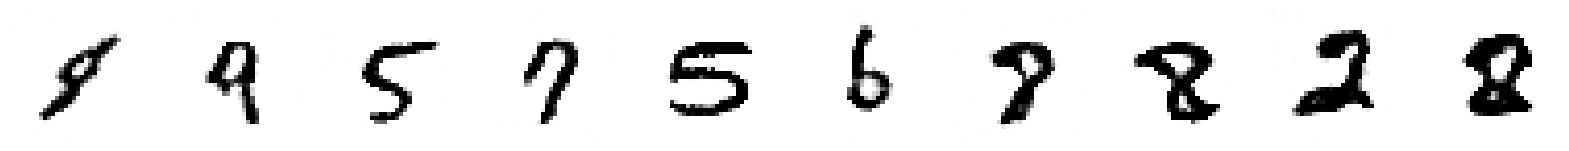


Saved to 07_01_ebm/output/example_img_058.png


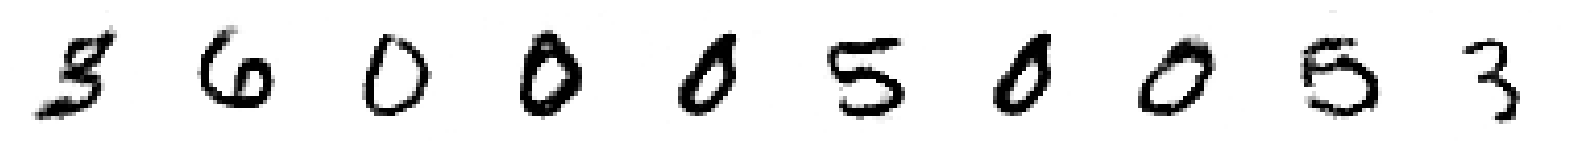

469/469 [==============================] - 272s 579ms/step - loss: -7.7328e-05 - reg: 1.0873e-04 - cdiv: -1.8606e-04 - real: 3.0224e-04 - fake: 1.1617e-04 - val_cdiv: -18.1178 - val_real: -0.0092 - val_fake: -18.1271
Epoch 60/60
469/469 [==============================] - ETA: 0s - loss: 1.9046e-04 - reg: 2.7782e-04 - cdiv: -8.7355e-05 - real: -5.6200e-05 - fake: -1.4356e-04
Saved to 07_01_ebm/output/generated_img_059.png


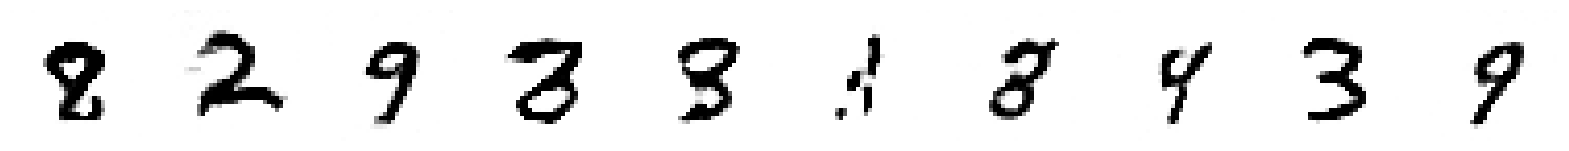


Saved to 07_01_ebm/output/example_img_059.png


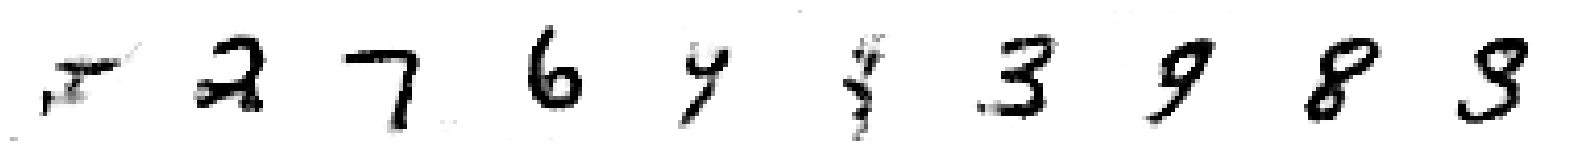

469/469 [==============================] - 272s 580ms/step - loss: 1.9046e-04 - reg: 2.7782e-04 - cdiv: -8.7355e-05 - real: -5.6200e-05 - fake: -1.4356e-04 - val_cdiv: -18.8079 - val_real: -0.0144 - val_fake: -18.8223
CPU times: user 4h 30min 58s, sys: 32.8 s, total: 4h 31min 31s
Wall time: 4h 39min 6s


In [17]:
%%time
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Generate images <a name="generate"></a>

In [18]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

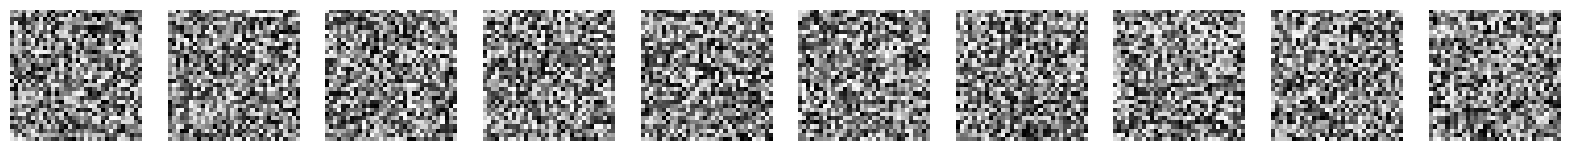

In [19]:
display(start_imgs)

In [20]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

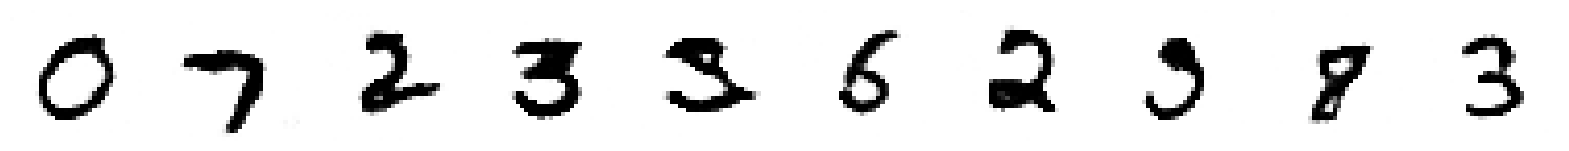

In [21]:
display(gen_img[-1].numpy())

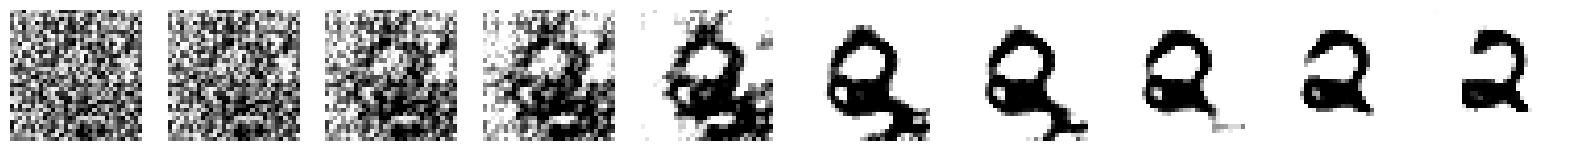

In [22]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))

In [23]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Friday, June 02, 2023
# Run Time: 04:39:20
